<a href="https://colab.research.google.com/github/nazmulhudabadhon/Computer-Vision-and-Deep-Learning-in-Medical-Imaging/blob/main/Breast_Cancer_Segmentation_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*Project (Breast Cancer Segmentation and Classification Using a Hybrid Model), by* ***Nazmul Huda Badhon***




---

#Exploring datasets, checking class imbalance and handling:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzipping both dataset: dataset-1(with mask) and dataset-2(for classification)

In [ ]:
import zipfile
import glob

zip_file1 = glob.glob('/content/drive/MyDrive/dataset/breast-ultrasound-images-dataset.zip')

for file in zip_file1:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('/content/breast_data_with_mask')

print('dataset-1 extracted successfully')

zip_file2 = glob.glob('/content/drive/MyDrive/dataset/BUSI_Corrected.zip')

for file in zip_file2:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('/content/breast_dataset_for_classification')

print('dataset-2 extracted successfully')

dataset-1 extracted successfully
dataset-2 extracted successfully


## Dataset with mask for segmentation, dataset-1:

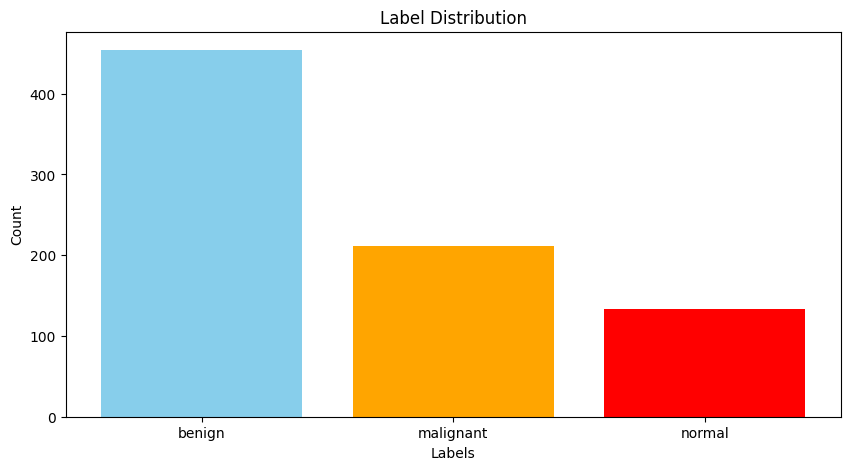

labels
benign       454
malignant    211
normal       133
Name: count, dtype: int64
Image dimensions: 495 x 491 pixels
Number of channels: 3


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Dataset path
dataset_path = '/content/breast_data_with_mask/Dataset_BUSI_with_GT'  # Replace with your dataset path

# Get image types and labels
image_types = []
labels = []

for folder_name in ['normal', 'benign', 'malignant']:
    folder_path = os.path.join(dataset_path, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') and not filename.endswith('_mask.png'):
            image_types.append(filename)
            labels.append(folder_name)

# Analyze label distribution
df = pd.DataFrame({'labels': labels})
label_counts = df['labels'].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'orange', 'red'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()
print(label_counts)

# Example: Get image characteristics (dimensions, channels)
example_image_path = os.path.join(dataset_path, 'normal', image_types[0])
image = cv2.imread(example_image_path)
height, width, channels = image.shape
print(f"Image dimensions: {width} x {height} pixels")
print(f"Number of channels: {channels}")

Load and display a sample ultrasound image and mask from Dataset 1:

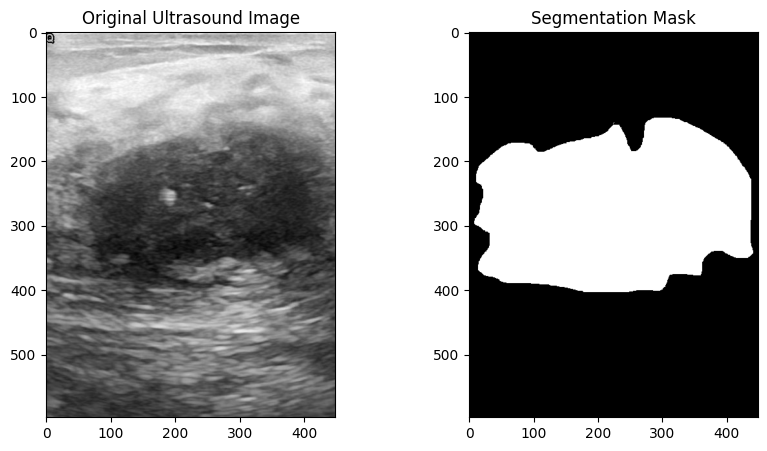

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# Load and display a sample ultrasound image and its mask from Dataset 1
image_path = "/content/breast_data_with_mask/Dataset_BUSI_with_GT/malignant/malignant (1).png"
mask_path = "/content/breast_data_with_mask/Dataset_BUSI_with_GT/malignant/malignant (1)_mask.png"

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Ultrasound Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Segmentation Mask")

plt.show()

##Handling class imbalance with Data Augmentation using Albumentation on ***breast_data_with_mask (dataset-1)***

Importing necessary libraries.

In [ ]:
import albumentations as A
import cv2
import os
import shutil
from concurrent.futures import ThreadPoolExecutor

Declaring function: augment_image_and_mask

In [ ]:
def augment_image_and_mask(image_path, mask_path, augmentation):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    # Ensure that images and masks are read in correctly
    if image is None:
      raise FileNotFoundError(f"Image not found at: {image_path}")
    if mask is None:
      raise FileNotFoundError(f"Mask not found at: {mask_path}")

    # Ensure both images are read as color images to be used with Albumentations
    if len(image.shape) == 2:
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if len(mask.shape) == 2:
      mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    # Apply the augmentation
    augmented = augmentation(image=image, mask=mask)
    aug_img = augmented['image']
    aug_mask = augmented['mask']

    return aug_img, aug_mask

Function for generating augmented image only:

In [ ]:
def augment_image(image_path, augmentation):
    image = cv2.imread(image_path)

    # Ensure that images and masks are read in correctly
    if image is None:
      raise FileNotFoundError(f"Image not found at: {image_path}")

    # Ensure both images are read as color images to be used with Albumentations
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Apply the augmentation
    augmented = augmentation(image=image)
    aug_img = augmented['image']

    return aug_img

Generating augmented data to the dataset-1:

In [ ]:
def augment_data(input_dir, output_dir, target_images):
    """Augments images to balance the dataset. Args:
        input_dir (str): Path to the original dataset.
        output_dir (str): Path to store augmented data.
        target_images (int): The target number of images per class."""

    # Define the augmentation pipeline
    augmentation = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5)
    ])

    # Process each class
    for class_name in ["malignant", "normal", "benign"]:
        input_class_dir = os.path.join(input_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        filenames = [f for f in os.listdir(input_class_dir) if f.endswith(".png") and "mask" not in f]
        num_original_images = len(filenames)
        num_augmentations_needed = max(0, target_images - num_original_images)  # Same target for all
        augmented_count = 0

        if num_original_images > 0:
            for i, filename in enumerate(filenames):
                image_path = os.path.join(input_class_dir, filename)

                # Handle masks for malignant and benign only
                if class_name in ["malignant", "benign"]:
                    mask_path = image_path.replace(".png", "_mask.png")
                    if not os.path.exists(mask_path):
                        print(f"Warning: Mask not found for image {filename}, skipping augmentation for this file.")
                        continue
                    shutil.copy(mask_path, output_class_dir)  # Copy original mask

                # Copy original image for all classes
                shutil.copy(image_path, output_class_dir)

                # Augmentation loop
                while augmented_count < num_augmentations_needed:
                    if class_name in ["malignant", "benign"]:
                        aug_img, aug_mask = augment_image_and_mask(image_path, mask_path, augmentation)
                        mask_save_path = os.path.join(output_class_dir, f"{filename[:-4]}_mask_aug{augmented_count}.png")
                        cv2.imwrite(mask_save_path, aug_mask)  # Save augmented mask
                    else:  # Normal class - only augment image
                        aug_img = augment_image(image_path, augmentation)

                    img_save_path = os.path.join(output_class_dir, f"{filename[:-4]}_aug{augmented_count}.png")
                    cv2.imwrite(img_save_path, aug_img)  # Save augmented image
                    augmented_count += 1

# Directory paths
input_dir = "/content/breast_data_with_mask/Dataset_BUSI_with_GT"
output_dir = "augmented_dataset_1"
target_images = 454 # set target image to the class with the max images

augment_data(input_dir, output_dir, target_images)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Checking classes

In [ ]:
import os

dataset_path = '/content/augmented_dataset_1' # Or where augmented dataset is stored

for folder_name in ['normal', 'benign', 'malignant']:
    folder_path = os.path.join(dataset_path, folder_name)
    image_count = 0
    mask_count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            if "mask" in filename:
                mask_count += 1
            else:
                image_count +=1

    print(f"Class {folder_name}: {image_count} images and {mask_count} masks")

Class normal: 454 images and 0 masks
Class benign: 454 images and 454 masks
Class malignant: 454 images and 454 masks


Analyzing and Visualizing the class distribution of dataset for dataset-1 after augmentation:

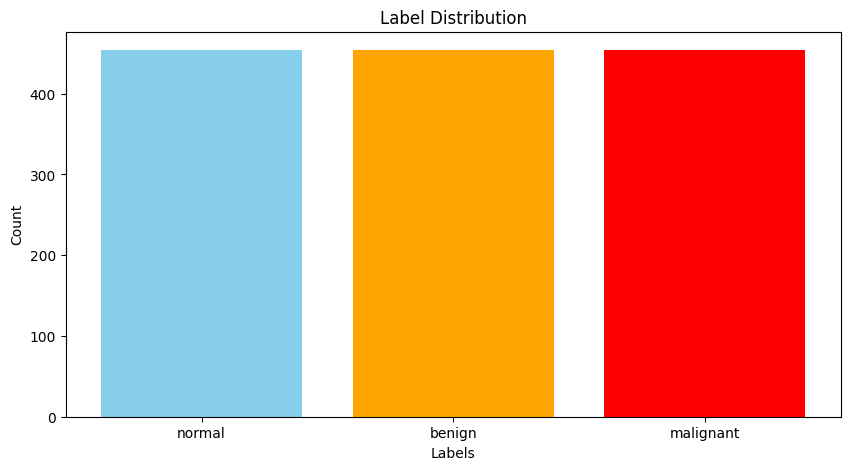

labels
normal       454
benign       454
malignant    454
Name: count, dtype: int64
Image dimensions: 495 x 491 pixels
Number of channels: 3


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import re

# Dataset path
dataset_path = '/content/augmented_dataset_1'

# Get image types and labels
image_types = []
labels = []

for folder_name in ['normal', 'benign', 'malignant']:
    folder_path = os.path.join(dataset_path, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') and not filename.endswith('_mask.png') and not re.search(r'_mask_aug\d+\.png$', filename):
            image_types.append(filename)
            labels.append(folder_name)

# Analyze label distribution
df = pd.DataFrame({'labels': labels})
label_counts = df['labels'].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'orange', 'red'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()
print(label_counts)

# Example: Get image characteristics (dimensions, channels)
example_image_path = os.path.join(dataset_path, 'normal', image_types[0])
image = cv2.imread(example_image_path)
height, width, channels = image.shape
print(f"Image dimensions: {width} x {height} pixels")
print(f"Number of channels: {channels}")

## Dataset for classification, dataset-2:

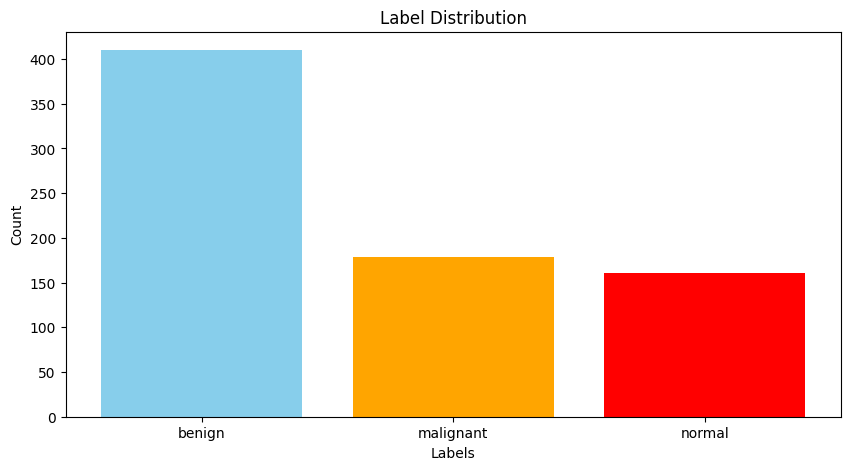

labels
benign       410
malignant    179
normal       161
Name: count, dtype: int64
Image dimensions: 495 x 491 pixels
Number of channels: 3


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Dataset path
dataset_path = '/content/breast_dataset_for_classification/BUSI_Corrected'

# Get image types and labels
image_types = []
labels = []

for folder_name in ['normal', 'benign', 'malignant']:
    folder_path = os.path.join(dataset_path, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') and not filename.endswith('_mask.png'):
            image_types.append(filename)
            labels.append(folder_name)

# Analyze label distribution
df = pd.DataFrame({'labels': labels})
label_counts = df['labels'].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'orange', 'red'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()
print(label_counts)

# Example: Get image characteristics (dimensions, channels)
example_image_path = os.path.join(dataset_path, 'normal', image_types[0])
image = cv2.imread(example_image_path)
height, width, channels = image.shape
print(f"Image dimensions: {width} x {height} pixels")
print(f"Number of channels: {channels}")

Load and display a sample ultrasound image from Dataset 2:



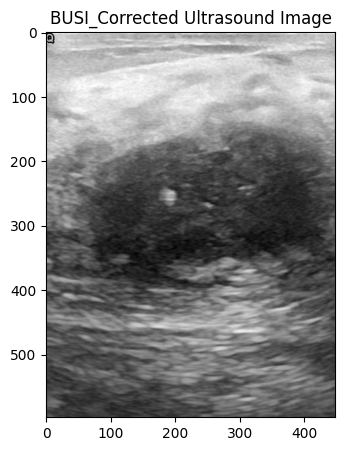

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# Load and display a sample ultrasound image and its mask from Dataset 1
image_path = "/content/breast_dataset_for_classification/BUSI_Corrected/malignant/malignant (1).png"

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))
plt.imshow(image, cmap='gray')
plt.title("BUSI_Corrected Ultrasound Image")

plt.show()

##Handling class imbalance with Data Augmentation using Albumentation on ***BUSI_Corrected (dataset-2)***

Importing necessary libraries.

In [ ]:
import albumentations as A
import cv2
import os
import shutil
from concurrent.futures import ThreadPoolExecutor

Function for generating augmented image only:

In [ ]:
def augment_image(image_path, augmentation):
    image = cv2.imread(image_path)

    # Ensure that images and masks are read in correctly
    if image is None:
      raise FileNotFoundError(f"Image not found at: {image_path}")

    # Ensure both images are read as color images to be used with Albumentations
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Apply the augmentation
    augmented = augmentation(image=image)
    aug_img = augmented['image']

    return aug_img

Generating augmented data to the dataset-1:

In [ ]:
def augment_data(input_dir, output_dir, target_images):
    """Augments images to balance the dataset. Args:
        input_dir (str): Path to the original dataset.
        output_dir (str): Path to store augmented data.
        target_images (int): The target number of images per class."""

    # Define the augmentation pipeline
    augmentation = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5)
    ])

    # Process each class
    for class_name in ["malignant", "normal"]:  # Only process malignant and normal
        input_class_dir = os.path.join(input_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        filenames = [f for f in os.listdir(input_class_dir) if f.endswith(".png")]
        num_original_images = len(filenames)
        num_augmentations_needed = max(0, target_images - num_original_images)
        augmented_count = 0

        if num_original_images > 0:
            for i, filename in enumerate(filenames):
                image_path = os.path.join(input_class_dir, filename)

                # Copy original image
                shutil.copy(image_path, output_class_dir)

                # Augmentation loop
                while augmented_count < num_augmentations_needed:
                    # Augment image
                    aug_img = augment_image(image_path, augmentation)

                    img_save_path = os.path.join(output_class_dir, f"{filename[:-4]}_aug{augmented_count}.png")
                    cv2.imwrite(img_save_path, aug_img)  # Save augmented image
                    augmented_count += 1

# Copy the 'benign' folder as is
    benign_input_dir = os.path.join(input_dir, "benign")
    benign_output_dir = os.path.join(output_dir, "benign")
    os.makedirs(benign_output_dir, exist_ok=True)
    for filename in os.listdir(benign_input_dir):
        if filename.endswith(".png"):
            shutil.copy(os.path.join(benign_input_dir, filename), benign_output_dir)


# Directory paths
input_dir = "/content/breast_dataset_for_classification/BUSI_Corrected"
output_dir = "augmented_dataset_2"
target_images = 410

augment_data(input_dir, output_dir, target_images)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Checking classes

In [ ]:
import os

dataset_path = '/content/augmented_dataset_2' # Or where augmented dataset is stored

for folder_name in ['normal', 'benign', 'malignant']:
    folder_path = os.path.join(dataset_path, folder_name)
    image_count = 0
    mask_count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            if "mask" in filename:
                mask_count += 1
            else:
                image_count +=1

    print(f"Class {folder_name}: {image_count} images and {mask_count} masks")

Class normal: 410 images and 0 masks
Class benign: 410 images and 0 masks
Class malignant: 410 images and 0 masks


Analyzing and Visualizing the class distribution of dataset for dataset-1 after augmentation:

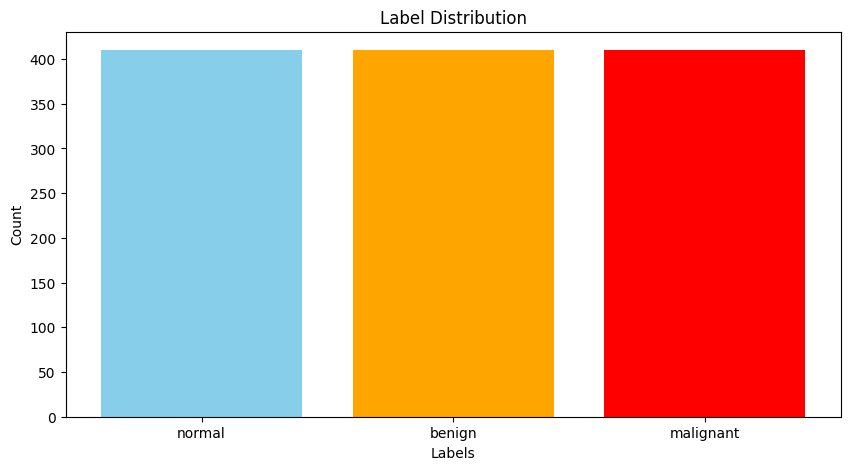

labels
normal       410
benign       410
malignant    410
Name: count, dtype: int64
Image dimensions: 763 x 611 pixels
Number of channels: 3


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import re

# Dataset path
dataset_path = '/content/augmented_dataset_2'

# Get image types and labels
image_types = []
labels = []

for folder_name in ['normal', 'benign', 'malignant']:
    folder_path = os.path.join(dataset_path, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_types.append(filename)
            labels.append(folder_name)

# Analyze label distribution
df = pd.DataFrame({'labels': labels})
label_counts = df['labels'].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'orange', 'red'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()
print(label_counts)

# Example: Get image characteristics (dimensions, channels)
example_image_path = os.path.join(dataset_path, 'normal', image_types[0])
image = cv2.imread(example_image_path)
height, width, channels = image.shape
print(f"Image dimensions: {width} x {height} pixels")
print(f"Number of channels: {channels}")

In [ ]:
# Zip the augmented dataset folder in one line
import shutil
shutil.make_archive('/content/drive/MyDrive/dataset/augmented_dataset_2', 'zip', output_dir)
print("Augmented dataset zipped and saved to Google Drive successfully!")

Augmented dataset zipped and saved to Google Drive successfully!


# **Part 01: Developing a Segmentation Model**

##Training the segmentation model using DATASET_1:

U-net Segmentation model have been used here to train the dataset-1.

In [ ]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

Loads and Preprocesses Data

In [ ]:
framObjTrain = {'img': [], 'mask': []}

def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=224):
    frameObj['img'] = []
    frameObj['mask'] = []

    imgNames = os.listdir(imgPath)

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for imgName in imgNames:
        if imgName.endswith('.png') and not imgName.endswith('_mask.png') and not imgName.endswith('_mask_1.png'):
            img = plt.imread(imgAddr + imgName)
            maskName1 = imgName.split('.png')[0] + '_mask.png'
            maskName2 = imgName.split('.png')[0] + '_mask_1.png'

            if os.path.exists(maskAddr + maskName1):
                mask1 = plt.imread(maskAddr + maskName1)

                # Resize and ensure 3 channels for images:
                img = cv2.resize(img, (shape, shape))
                if len(img.shape) == 2:  # If grayscale, convert to 3 channels
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                # Resize and ensure 1 channel for masks:
                mask1 = cv2.resize(mask1, (shape, shape))
                if len(mask1.shape) == 3: # If RGB, convert to grayscale
                    mask1 = cv2.cvtColor(mask1, cv2.COLOR_RGB2GRAY)
                mask1 = mask1[..., np.newaxis]  # Add channel dimension if missing

                frameObj['img'].append(img)
                frameObj['mask'].append(mask1)
            if os.path.exists(maskAddr + maskName2):
                mask2 = plt.imread(maskAddr + maskName2)

                # Resize and ensure 3 channels for images:
                img = cv2.resize(img, (shape, shape))
                if len(img.shape) == 2:  # If grayscale, convert to 3 channels
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                # Resize and ensure 1 channel for masks:
                mask2 = cv2.resize(mask2, (shape, shape))
                if len(mask2.shape) == 3: # If RGB, convert to grayscale
                    mask2 = cv2.cvtColor(mask2, cv2.COLOR_RGB2GRAY)
                mask2 = mask2[..., np.newaxis]  # Add channel dimension if missing

                frameObj['img'].append(img)
                frameObj['mask'].append(mask2)

    print("Total images loaded:", len(frameObj['img']))
    return frameObj

###Loading Benign Samples and Predicting Mask and save the model for  benign_predicted_mask

In [ ]:
# Load benign samples
benignObjTrain = LoadData(framObjTrain, imgPath='/content/augmented_dataset_1/benign',
                        maskPath='/content/augmented_dataset_1/benign', shape=224)

Total images loaded: 437


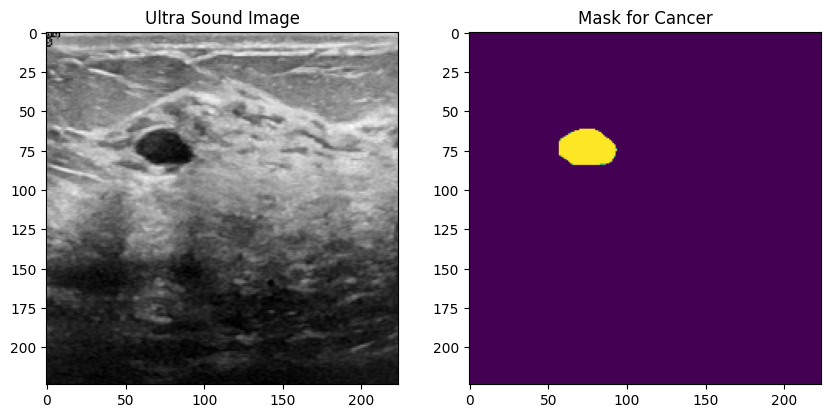

In [ ]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(benignObjTrain['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(benignObjTrain['mask'][1])
plt.title('Mask for Cancer')
plt.show()

In [ ]:
!pip install superml

Spliting the data into training and testing sets using train_test_split.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(benignObjTrain['img'], benignObjTrain['mask'], test_size = 0.30, random_state = 42)

Building the U-Net Model by defining functions, **Conv2dBlock** and **GiveMeUnet**:

In [ ]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x

def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

#### Model Instantiation

In [ ]:
batch_size = 128
inputs = tf.keras.layers.Input((224, 224, 3), name='keras_tensor_228')
rkoshaheds_model = GiveMeUnet(inputs, droupouts= 0.3)
rkoshaheds_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
rkoshaheds_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_228          │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 16)   │            448 │ keras_tensor_228[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 224, 224, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 224, 224, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 112, 112, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 112, 112, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
hisVal = rkoshaheds_model.fit({'keras_tensor_228': np.array(X_train)}, np.array(y_train), batch_size=batch_size, epochs=180)

Epoch 1/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 121s 17s/step - accuracy: 0.4030 - loss: 0.8563
Epoch 2/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 646ms/step - accuracy: 0.3924 - loss: 0.7897
Epoch 3/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 651ms/step - accuracy: 0.4660 - loss: 0.7353
Epoch 4/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step - accuracy: 0.6115 - loss: 0.6788
Epoch 5/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step - accuracy: 0.7638 - loss: 0.6214
Epoch 6/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step - accuracy: 0.8589 - loss: 0.5666
Epoch 7/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step - accuracy: 0.9049 - loss: 0.5083
Epoch 8/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 666ms/step - accuracy: 0.9164 - loss: 0.4773
Epoch 9/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - accuracy: 0.9259 - loss: 0.4540
Epoch 10/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 672ms/step - accuracy: 0.9295 - loss: 0.4272
Epoch 11/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 0.9279 - loss: 0.4151
Epoch 12/180
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step - accuracy:

In [ ]:
retVal = rkoshaheds_model.fit({'keras_tensor_228': np.array(X_test)}, np.array(y_test), epochs = 180)

Epoch 1/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.9621 - loss: 0.1364
Epoch 2/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.9596 - loss: 0.1391
Epoch 3/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.9625 - loss: 0.1278
Epoch 4/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.9525 - loss: 0.1514
Epoch 5/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.9549 - loss: 0.1470
Epoch 6/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.9529 - loss: 0.1432
Epoch 7/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.9587 - loss: 0.1273
Epoch 8/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.9560 - loss: 0.1324
Epoch 9/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.9626 - loss: 0.1161
Epoch 10/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.9646 - loss: 0.1099
Epoch 11/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.9698 - loss: 0.0960
Epoch 12/180
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 

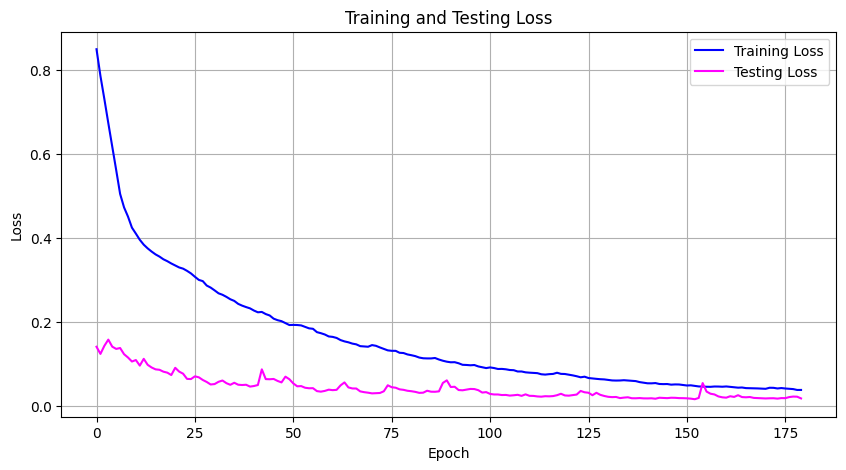

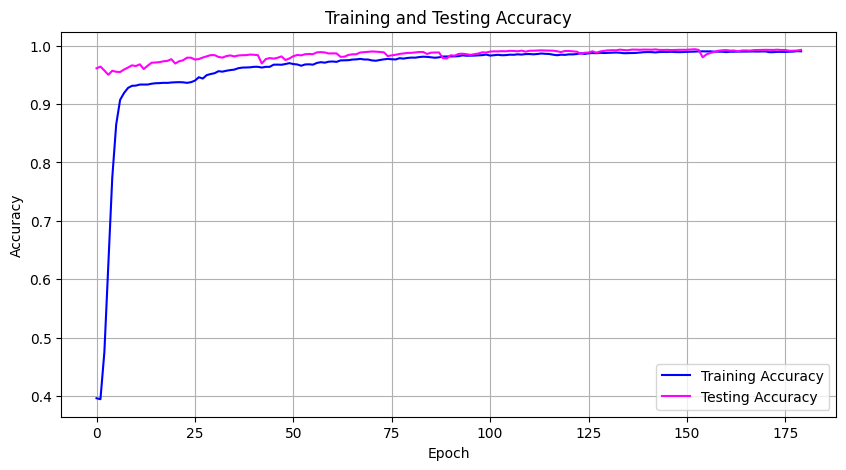

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Accessing training loss ang accuracy:
training_loss = hisVal.history['loss']
training_accuracy = hisVal.history['accuracy']

# Accessing testing loss and accuracy:
testing_loss = retVal.history['loss']
testing_accuracy = retVal.history['accuracy']

# Plotting training and testing metrics:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.plot(training_loss, label='Training Loss', color='blue')
plt.plot(testing_loss, label='Testing Loss', color='magenta')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy', color='blue')
plt.plot(testing_accuracy, label='Testing Accuracy', color='magenta')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

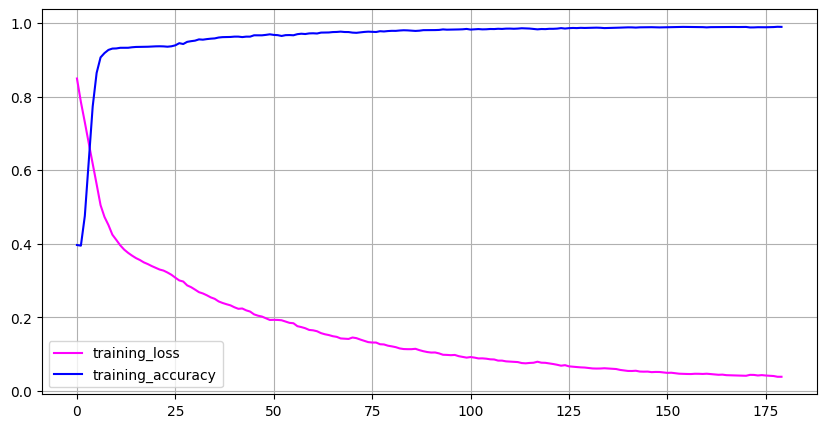

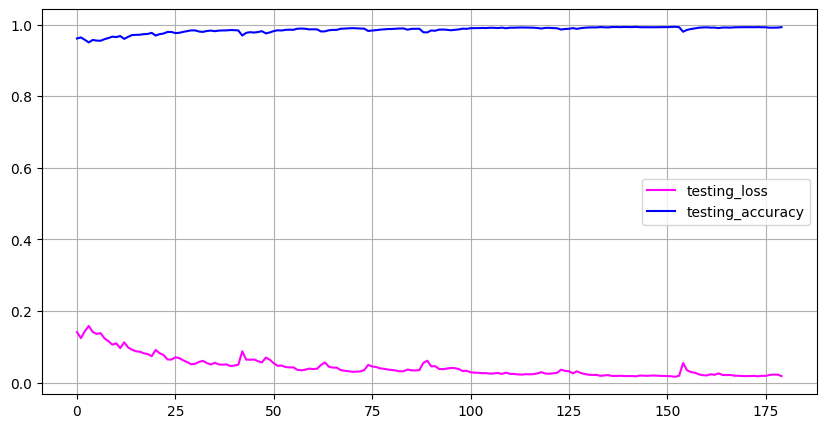

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

plt.figure(figsize=(10, 5))
plt.plot(hisVal.history['loss'], label = 'training_loss', color='magenta')
plt.plot(hisVal.history['accuracy'], label = 'training_accuracy', color='blue')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.plot(retVal.history['loss'], label = 'testing_loss', color='magenta')
plt.plot(retVal.history['accuracy'], label = 'testing_accuracy', color='blue')
plt.legend()
plt.grid(True)

In [ ]:
#Testing
def predict16 (valMap, model, shape = 224):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]

    imgProc = img [0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)
    return predictions, imgProc, mask

def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


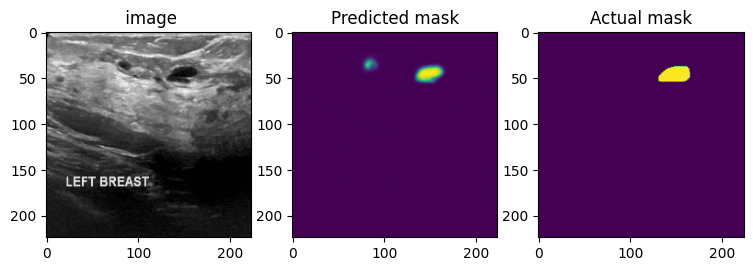

In [ ]:
sixteenPrediction, actuals, masks = predict16(benignObjTrain, rkoshaheds_model)
Plotter(actuals[11], sixteenPrediction[11][:,:,0], masks[11])


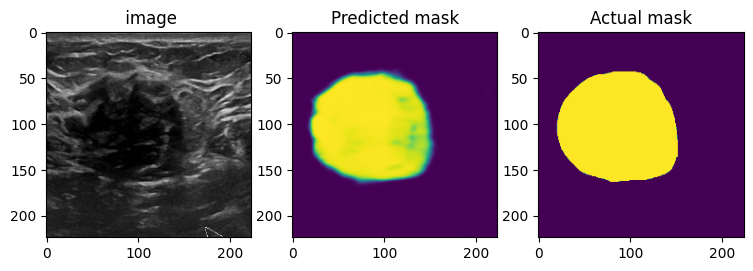

In [ ]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

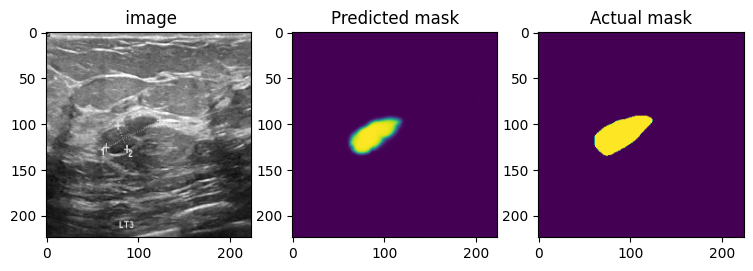

In [ ]:
Plotter(actuals[9], sixteenPrediction[9][:,:,0], masks[9])

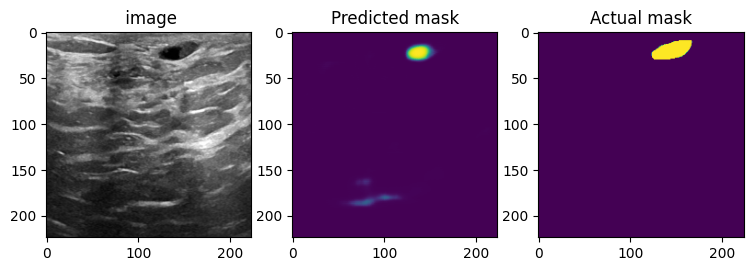

In [ ]:
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

In [ ]:
#Saving Model
rkoshaheds_model.save('/content/drive/MyDrive/dataset/benign_predicted_mask.h5')

###Loading Malignent Samples and Predicting Mask and save the model for malignant_predicted_mask

In [ ]:
# Load malignant samples
malignantObjTrain = LoadData(framObjTrain, imgPath='/content/augmented_dataset_1/malignant',
                        maskPath='/content/augmented_dataset_1/malignant', shape=224)

Total images loaded: 210


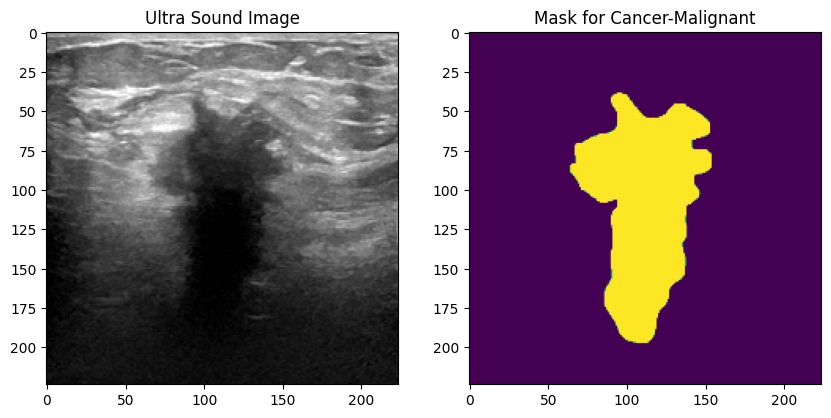

In [ ]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(malignantObjTrain['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(malignantObjTrain['mask'][1])
plt.title('Mask for Cancer-Malignant')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(malignantObjTrain['img'], malignantObjTrain['mask'], test_size = 0.30, random_state = 42)

In [ ]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x

def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    output = tf.keras.layers.Reshape((224, 224, 1), dtype=tf.float32)(output)

    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

#### Model Instantiation

In [ ]:
batch_size = 128
inputs = tf.keras.layers.Input((224, 224, 3), name='keras_tensor_228')
rkoshaheds_model = GiveMeUnet(inputs, droupouts= 0.3)
rkoshaheds_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
rkoshaheds_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_228          │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 224, 224, 16)   │            448 │ keras_tensor_228[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 224, 224, 16)   │             64 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 224, 224, 16)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 224, 224, 16)   │          2,320 │ activation_36[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 224, 224, 16)   │             64 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_37             │ (None, 224, 224, 16)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 112, 112, 16)   │              0 │ activation_37[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 112, 112, 16)   │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 112, 112, 32)   │          4,640 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 112, 112, 32)   │            128 │ conv2d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 112, 112, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ activation_38[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 112, 112, 32)   │            128 │ conv2d_41[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_39             │ (None, 112, 112, 32)   │              0 │ batch_normalization_3… │
│ (Activation)         

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
hisVal = rkoshaheds_model.fit({'keras_tensor_228': np.array(X_train)}, np.array(y_train), batch_size=batch_size, epochs=180)

Epoch 1/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 23s/step - accuracy: 0.5871 - loss: 0.6736
Epoch 2/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.6360 - loss: 0.6365
Epoch 3/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.6786 - loss: 0.6066
Epoch 4/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7367 - loss: 0.5695
Epoch 5/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7911 - loss: 0.5351
Epoch 6/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8354 - loss: 0.5057
Epoch 7/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8649 - loss: 0.4760
Epoch 8/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8860 - loss: 0.4437
Epoch 9/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.8874 - loss: 0.4281
Epoch 10/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.8932 - loss: 0.4084
Epoch 11/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8998 - loss: 0.3907
Epoch 12/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 

In [ ]:
retVal = rkoshaheds_model.fit({'keras_tensor_228': np.array(X_test)}, np.array(y_test), epochs = 180)

Epoch 1/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 28s/step - accuracy: 0.8923 - loss: 0.3157
Epoch 2/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 231ms/step - accuracy: 0.9007 - loss: 0.2783
Epoch 3/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9130 - loss: 0.2278
Epoch 4/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.9161 - loss: 0.2088
Epoch 5/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9238 - loss: 0.1842
Epoch 6/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9229 - loss: 0.1827
Epoch 7/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.9292 - loss: 0.1693
Epoch 8/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9332 - loss: 0.1618
Epoch 9/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.9329 - loss: 0.1579
Epoch 10/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9385 - loss: 0.1518
Epoch 11/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.9436 - loss: 0.1447
Epoch 12/180
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy:

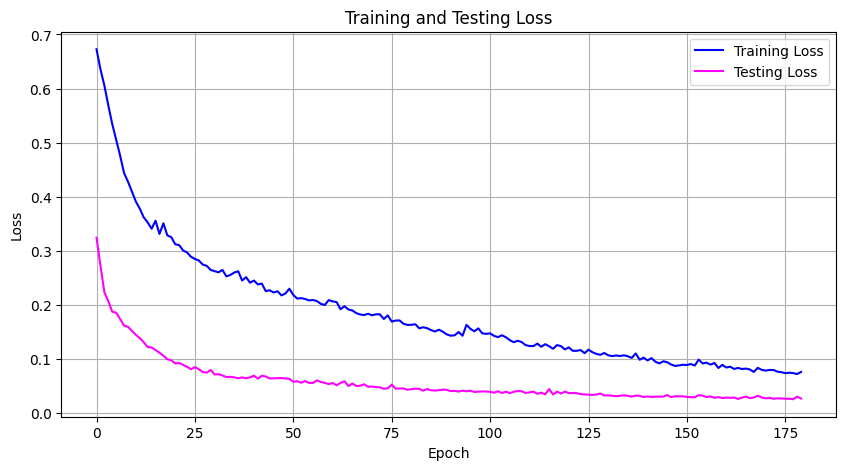

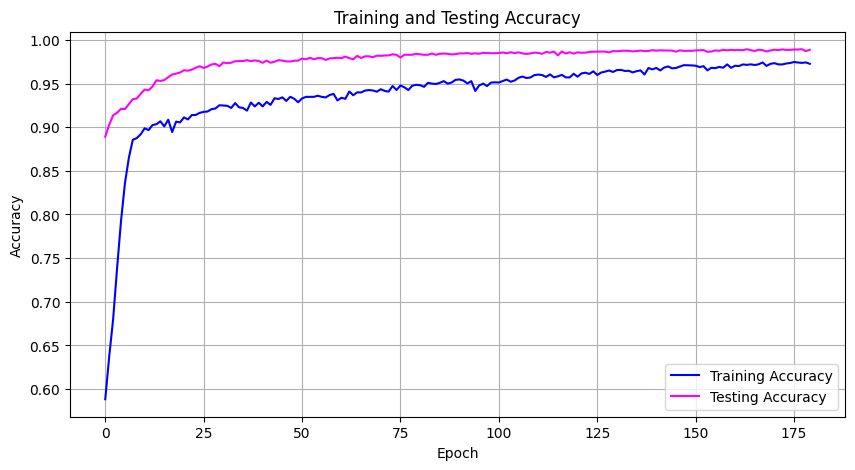

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Accessing training loss ang accuracy:
training_loss = hisVal.history['loss']
training_accuracy = hisVal.history['accuracy']

# Accessing testing loss and accuracy:
testing_loss = retVal.history['loss']
testing_accuracy = retVal.history['accuracy']

# Plotting training and testing metrics:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.plot(training_loss, label='Training Loss', color='blue')
plt.plot(testing_loss, label='Testing Loss', color='magenta')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy', color='blue')
plt.plot(testing_accuracy, label='Testing Accuracy', color='magenta')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

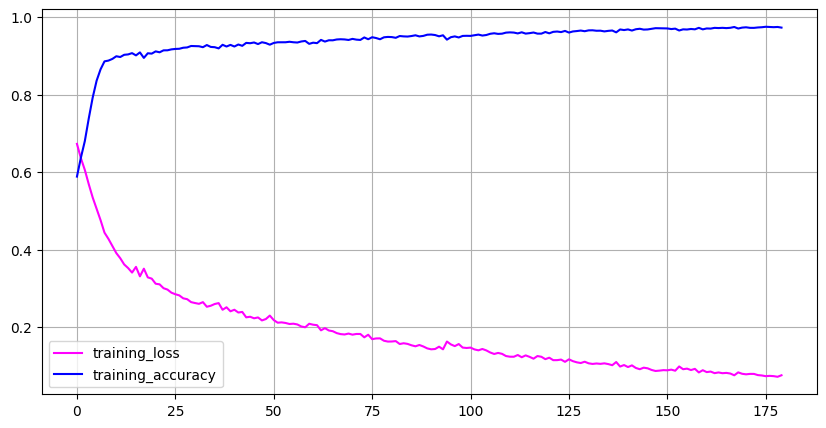

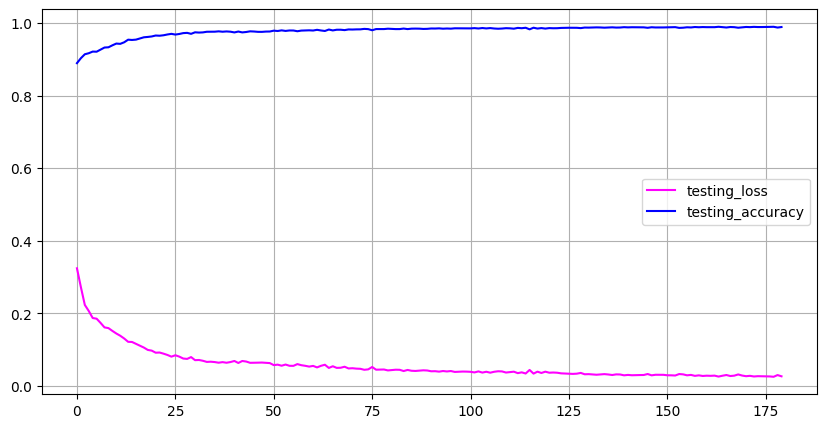

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

plt.figure(figsize=(10, 5))
plt.plot(hisVal.history['loss'], label = 'training_loss', color='magenta')
plt.plot(hisVal.history['accuracy'], label = 'training_accuracy', color='blue')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.plot(retVal.history['loss'], label = 'testing_loss', color='magenta')
plt.plot(retVal.history['accuracy'], label = 'testing_accuracy', color='blue')
plt.legend()
plt.grid(True)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_228']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


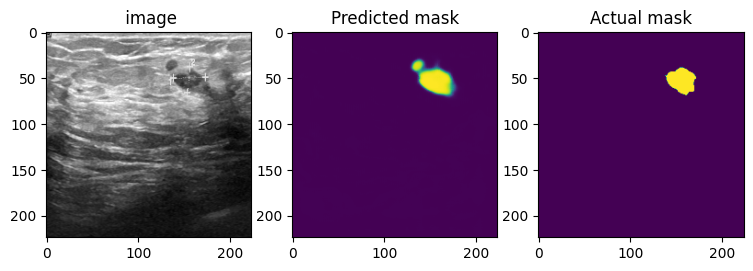

In [ ]:
sixteenPrediction, actuals, masks = predict16(malignantObjTrain, rkoshaheds_model)
Plotter(actuals[11], sixteenPrediction[11][:,:,0], masks[11])

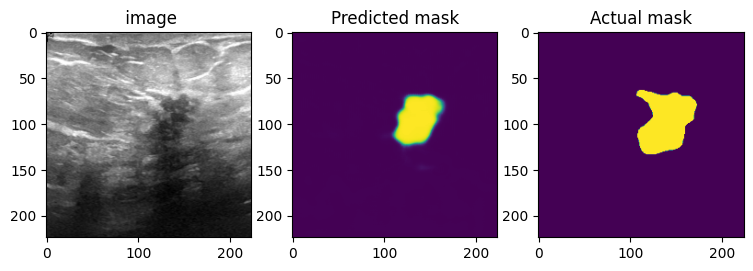

In [ ]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

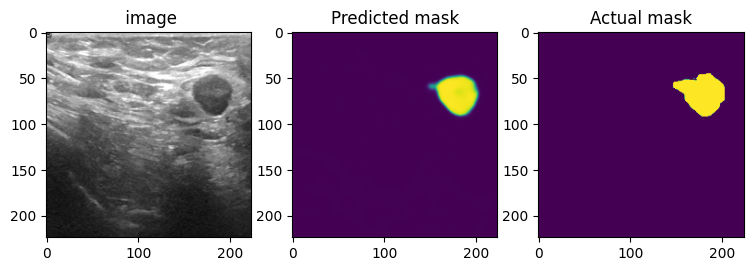

In [ ]:
Plotter(actuals[9], sixteenPrediction[9][:,:,0], masks[9])

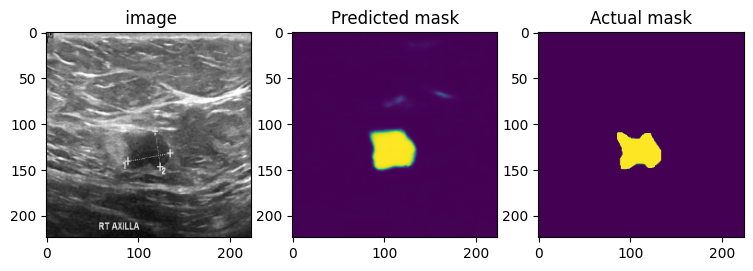

In [ ]:
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

In [ ]:
#Saving Model
rkoshaheds_model.save('/content/drive/MyDrive/dataset/malignant_predicted_mask.h5')

##Using the trained model to segment images from DATASET_2:

Loading the trained model:

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained U-Net models
benign_model = load_model('/content/drive/MyDrive/dataset/benign_predicted_mask.h5', compile=False)
malignant_model = load_model('/content/drive/MyDrive/dataset/malignant_predicted_mask.h5', compile=False)

Prepare Dataset 2 for Segmentation

In [ ]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model

# Path to Dataset 2 images
dataset2_path = '/content/augmented_dataset_2'

# Output paths for segmented masks
benign_masks_path = '/content/benign_segmented_image'
malignant_masks_path = '/content/malignant_segmented_image'

# Create output folders if they do not exist
os.makedirs(benign_masks_path, exist_ok=True)
os.makedirs(malignant_masks_path, exist_ok=True)

IMAGE_SIZE = (224, 224)

# Load the trained U-Net models
benign_model = load_model('/content/drive/MyDrive/dataset/benign_predicted_mask.h5', compile=False)
malignant_model = load_model('/content/drive/MyDrive/dataset/malignant_predicted_mask.h5', compile=False)

**Segmenting mask:**
Here I used, bitwise_and operation to segment the mask from dataset 2 using the saved model.

In [ ]:
# Traverse through the nested directories
for class_dir in os.listdir(dataset2_path):
    class_path = os.path.join(dataset2_path, class_dir)

    # Process only 'benign' and 'malignant' folders
    if class_dir in ['benign', 'malignant'] and os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                try:
                    # Load image
                    image_path = os.path.join(class_path, filename)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                    if image is None:
                        print(f"Warning: Unable to load image {filename}. Skipping.")
                        continue

                    # Convert grayscale to RGB
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

                    # Preprocess image
                    resized_image = cv2.resize(image_rgb, IMAGE_SIZE)
                    input_image = resized_image / 255.0  # Normalize to [0, 1]
                    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

                    # Predict masks using both models
                    benign_mask = benign_model.predict(input_image)[0, :, :, 0]
                    malignant_mask = malignant_model.predict(input_image)[0, :, :, 0]

                    # Apply masks to original image using bitwise AND
                    benign_segmented = cv2.bitwise_and(resized_image, resized_image, mask=(benign_mask > 0.5).astype(np.uint8) * 255)
                    malignant_segmented = cv2.bitwise_and(resized_image, resized_image, mask=(malignant_mask > 0.5).astype(np.uint8) * 255)

                    # Save the segmented images (result of bitwise AND)
                    if class_dir == 'benign':
                        cv2.imwrite(os.path.join(benign_masks_path, f"benign_segmented_{filename}"), benign_segmented)
                    elif class_dir == 'malignant':
                        cv2.imwrite(os.path.join(malignant_masks_path, f"malignant_segmented_{filename}"), malignant_segmented)

                except Exception as e:
                    print(f"Error processing {filename}: {e}")

print("The masks have been segmented and saved in separate folders.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

#**Part 02: Processing**

##Merge the segmented datasets

Merging and Saving Segmented Images

In [ ]:
import shutil
import os

output_folder = '/content/merged_images'  #  output folder path
os.makedirs(output_folder, exist_ok=True)  # Create if it doesn't exist

# Copy segmented images
benign_segmented_path = '/content/benign_segmented_image'  # Path to benign segmented images
malignant_segmented_path = '/content/malignant_segmented_image'  # Path to malignant segmented images
normal_segmented_path = '/content/augmented_dataset_2/normal'  # Path to normal  images

for path, class_name in [(benign_segmented_path, 'benign'),
                         (malignant_segmented_path, 'malignant'),
                         (normal_segmented_path, 'normal')]:
    # Create class subdirectory within output_folder
    os.makedirs(os.path.join(output_folder, class_name), exist_ok=True)

    for filename in os.listdir(path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            source_path = os.path.join(path, filename)
            destination_path = os.path.join(output_folder, class_name, filename)
            shutil.copy(source_path, destination_path)

In [ ]:
import shutil
shutil.make_archive('/content/drive/MyDrive/dataset/merged_images', 'zip', output_folder)

'/content/drive/MyDrive/dataset/merged_images.zip'

Folder 'normal' contains 410 files.
Folder 'benign' contains 410 files.
Folder 'malignant' contains 410 files.


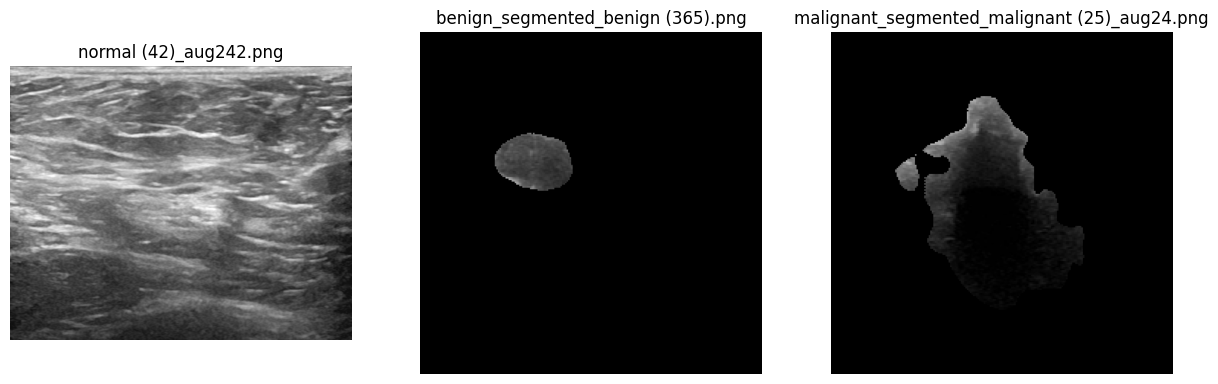

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# Load and display a sample ultrasound image and its mask from Dataset 1
base_image_path = '/content/merged_images'
subfolders = ['normal', 'benign', 'malignant']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 5 columns

# Iterate through subfolders and plot one image from each
for i, subfolder in enumerate(subfolders):
    folder_path = os.path.join(base_image_path, subfolder)
    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Folder '{subfolder}' contains {file_count} files.")

    input_path = os.path.join(base_image_path, subfolder)

    # Get a list of image files and sort them
    image_files = [f.path for f in os.scandir(input_path) if f.is_file()]
    image_files.sort()

    # Get the first image file (after sorting)
    image_file = image_files[259]
    image_name = os.path.basename(image_file)  # Get the image file name

    # Read and display the image
    image = cv2.imread(image_file)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    axes[i].imshow(image_rgb)
    axes[i].set_title(subfolder)
    axes[i].set_title(f"{image_name}")  # Include image name in title
    axes[i].axis('off')  # Turn off axis ticks and labels

plt.show()

#**Part 03: Developing the Hybrid Classification Model:**

In [ ]:
import zipfile
import glob

zip_file1 = glob.glob('/content/drive/MyDrive/dataset/merged_images.zip')

for file in zip_file1:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('/content/merged_dataset')

print('merged_dataset extracted successfully')

merged_dataset extracted successfully


##Dataset Split

0.7: 70% of the data will be used for training.

0.2: 20% of the data will be used for validation.

0.1: 10% of the data will be used for testing.

In [ ]:
!pip install split-folders

Train the classification model using segmented Regions of Interest (ROI) from the **merged dataset**.



In [ ]:
import splitfolders
import os

input = '/content/merged_dataset'
output = '/content/split_dataset'

os.makedirs(output, exist_ok=True)

splitfolders.ratio(input, output, seed=42, ratio=(0.7, 0.2, 0.1)) # train = 70%, val = 20%, test = 10%

Copying files: 1230 files [00:00, 2357.06 files/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0, MobileNetV2
from sklearn.metrics import classification_report

In [ ]:
training_set = tf.keras.utils.image_dataset_from_directory('/content/split_dataset/train',   #training dataset
                                            labels='inferred',
                                            image_size = (224,224),
                                            batch_size = 64,
                                            label_mode = 'categorical',
                                            shuffle = True)

val_set = tf.keras.utils.image_dataset_from_directory('/content/split_dataset/val',  #validation dataset
                                            labels='inferred',
                                            image_size = (224,224),
                                            batch_size = 64,
                                            label_mode = 'categorical',
                                            shuffle = False)

test_set = tf.keras.utils.image_dataset_from_directory('/content/split_dataset/test',  #test dataset
                                            labels='inferred',
                                            image_size = (224,224),
                                            batch_size = 64,
                                            label_mode = 'categorical',
                                            shuffle = False)

def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # Convert to float32
    image = image / 255.0  # Rescale to [0, 1]
    return image, label

training_set = training_set.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 861 files belonging to 3 classes.
Found 246 files belonging to 3 classes.
Found 123 files belonging to 3 classes.


##VGG16
###This model gives us best accuracy.

In [ ]:
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model_vgg16.trainable = False

x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

vgg16_model = Model(inputs=base_model_vgg16.input, outputs=output)
vgg16_model.summary()

vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =0.01),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │              

 Total params: 14,716,227 (56.14 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
filepath = "/content/VGG16.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq=2)

log_csv = CSVLogger('/content/VGG16.csv', separator=',', append=False)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks_list = [checkpoint1, log_csv, early_stopping]

history = vgg16_model.fit(
    training_set,
    epochs=100,
    validation_data=val_set,
    verbose = 1
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 770ms/step - accuracy: 0.4795 - loss: 1.1248 - val_accuracy: 0.9065 - val_loss: 0.4247
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 362ms/step - accuracy: 0.8478 - loss: 0.4135 - val_accuracy: 0.9268 - val_loss: 0.2926
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 353ms/step - accuracy: 0.9051 - loss: 0.2947 - val_accuracy: 0.9390 - val_loss: 0.2280
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.9038 - loss: 0.2572 - val_accuracy: 0.9553 - val_loss: 0.1939
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 358ms/step - accuracy: 0.9232 - loss: 0.2298 - val_accuracy: 0.9350 - val_loss: 0.1827
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.9235 - loss: 0.2064 - val_accuracy: 0.9512 - val_loss: 0.1711
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.9269 - loss: 0.2062 - val_accuracy: 0.9512 - val_loss: 0.1625
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.9297 - loss: 0.1913 - val_ac

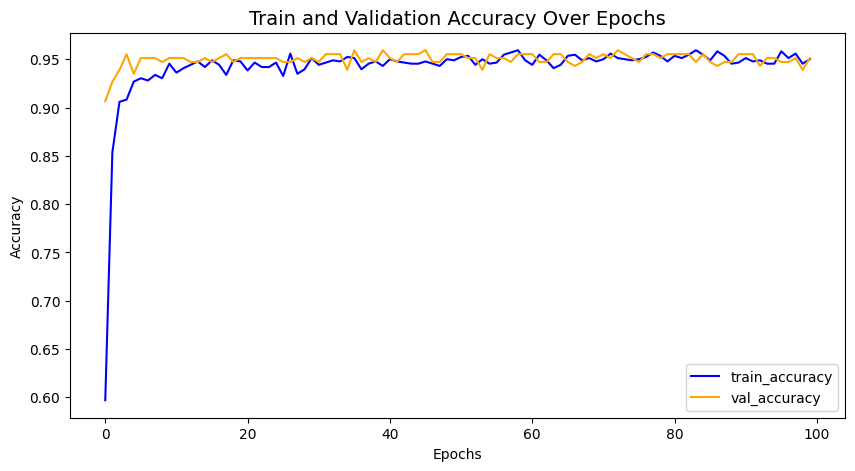

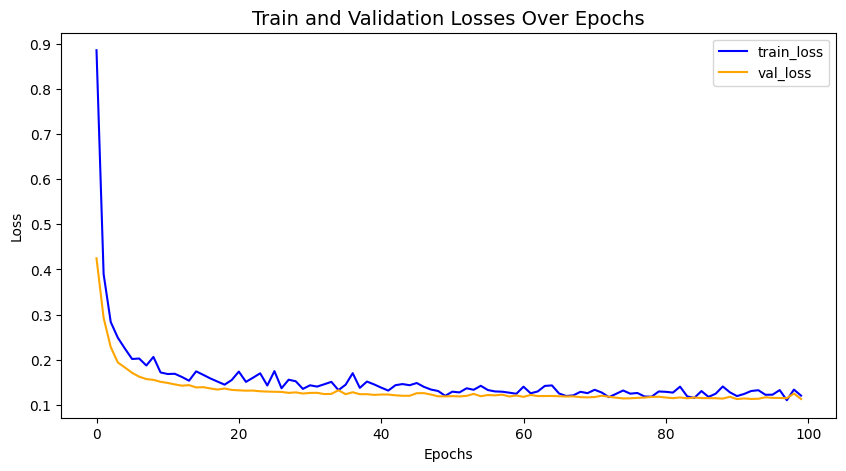

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))

plt.plot(history.history["accuracy"], label="train_accuracy", color='blue')
plt.plot(history.history["val_accuracy"], label="val_accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()

# Plot training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(history.history["loss"], label="train_loss", color='blue')
plt.plot(history.history["val_loss"], label="val_loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 16s/step


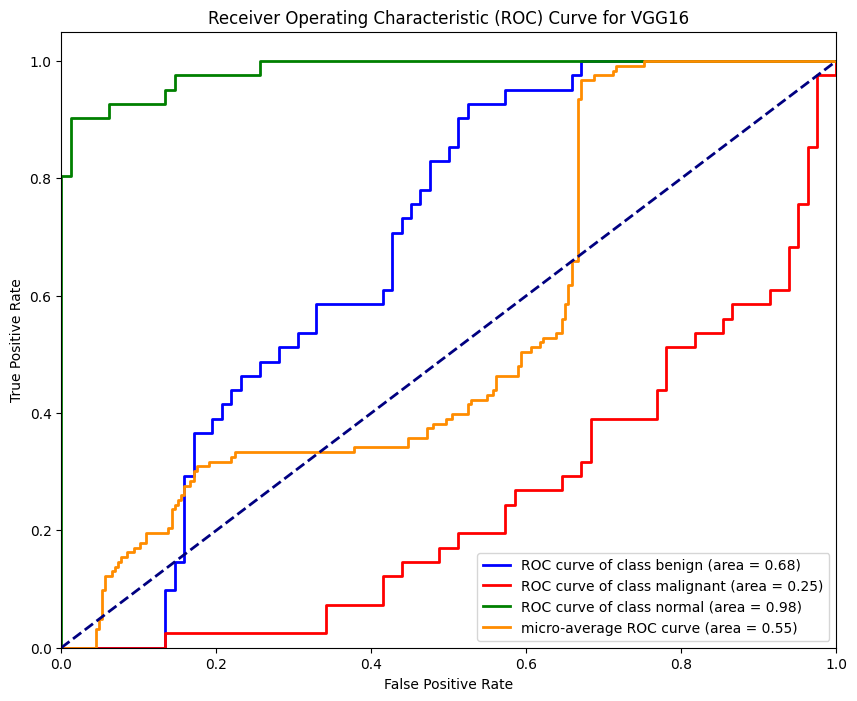

In [ ]:
# Get predictions for VGG16
y_pred_vgg16 = vgg16_model.predict(test_set)  # Add this line
y_pred_classes = np.argmax(y_pred_vgg16, axis=1)  # Convert to class labels

# ROC Curve for VGG16
y_true_bin = label_binarize(y_true_classes, classes=np.unique(y_true_classes))
n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_vgg16[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_vgg16.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2,
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for VGG16')
plt.legend(loc="lower right")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


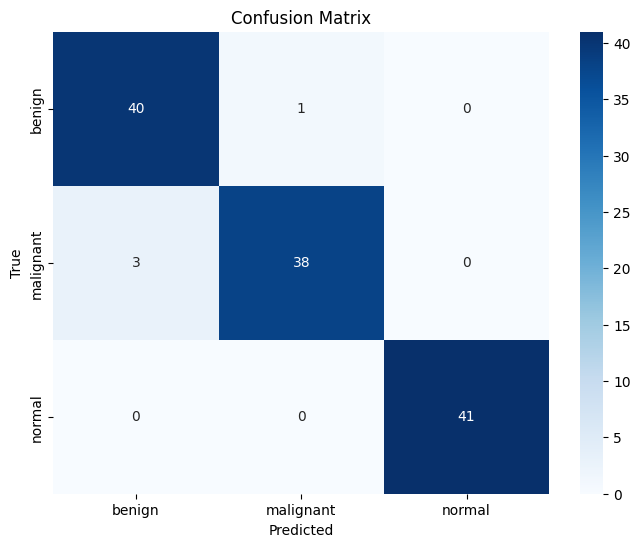

              precision    recall  f1-score   support

           0       0.93      0.98      0.95        41
           1       0.97      0.93      0.95        41
           2       1.00      1.00      1.00        41

    accuracy                           0.97       123
   macro avg       0.97      0.97      0.97       123
weighted avg       0.97      0.97      0.97       123



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = vgg16_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices
class_names = ['benign', 'malignant', 'normal']

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)

##Res-Net50
###The model gives us satisfactory prediction.

In [ ]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet.trainable = False

x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

resnet_model = Model(inputs=base_model_resnet.input, outputs=output)
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
filepath = "/content/ResNet50.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq= 2)

log_csv = CSVLogger('/content/ResNet50.csv', separator=',', append=False)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks_list = [checkpoint1, log_csv, early_stopping]

resnet_history = resnet_model.fit(
    training_set,
    epochs=100,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/100
 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.3550 - loss: 1.6836

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 857ms/step - accuracy: 0.3601 - loss: 1.5334 - val_accuracy: 0.5122 - val_loss: 1.0557
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4389 - loss: 1.1090 - val_accuracy: 0.6504 - val_loss: 0.8740
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.5994 - loss: 0.8708 - val_accuracy: 0.7520 - val_loss: 0.7541
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.6508 - loss: 0.7812 - val_accuracy: 0.7439 - val_loss: 0.7061
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.6890 - loss: 0.7466 - val_accuracy: 0.8496 - val_loss: 0.6622
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.6906 - loss: 0.7105 - val_accuracy: 0.8577 - val_loss: 0.6008
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.7200 - loss: 0.6557 - val_accuracy: 0.8577 - val_loss: 0.5720
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.7530 - loss: 0.6360 - val_accuracy: 0.865

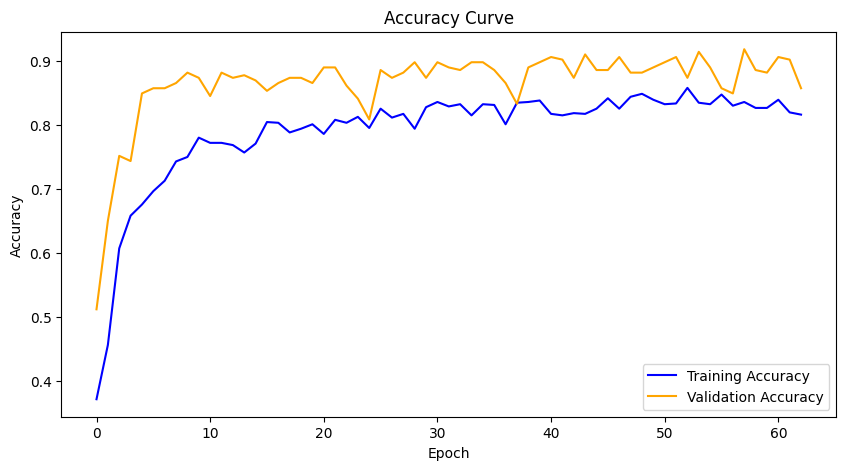

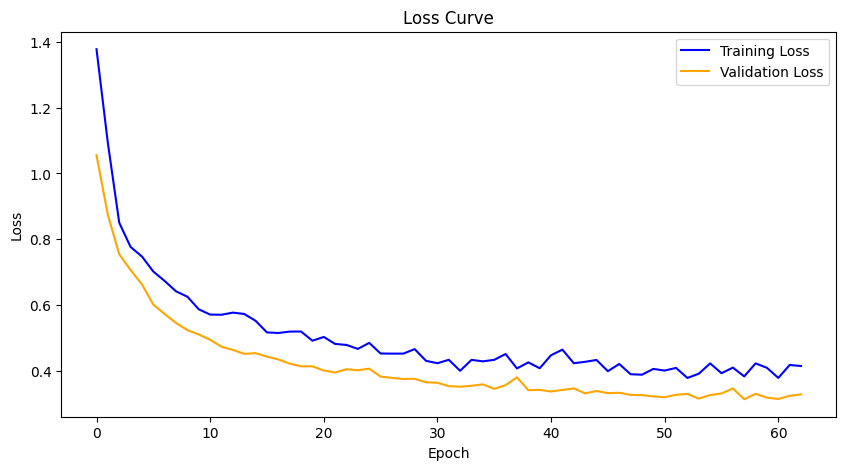

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# Load data from CSV file
data = pd.read_csv('/content/ResNet50.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy', color='blue')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss', color='blue')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step


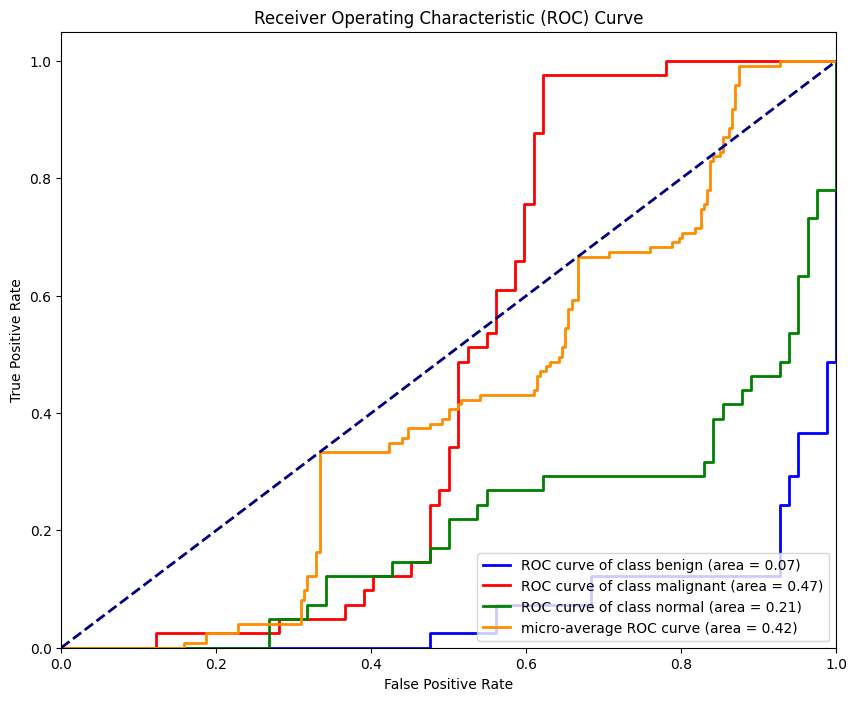

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get predictions for ResNet50
y_pred_resnet = resnet_model.predict(test_set)

# Assuming you have a list of class names
class_names = ['benign', 'malignant', 'normal']

# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(y_true_classes, classes=np.unique(y_true_classes))
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_resnet[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_resnet.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class with class names
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']  # Adjust colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))  # Use class_names[i]

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2,
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step


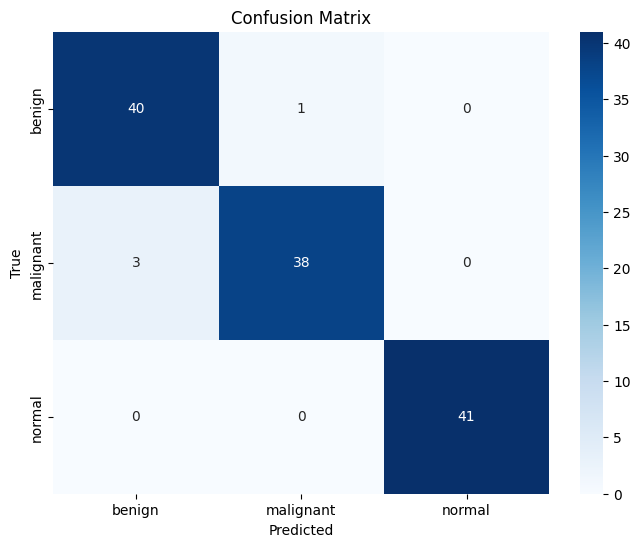

              precision    recall  f1-score   support

           0       0.93      0.98      0.95        41
           1       0.97      0.93      0.95        41
           2       1.00      1.00      1.00        41

    accuracy                           0.97       123
   macro avg       0.97      0.97      0.97       123
weighted avg       0.97      0.97      0.97       123



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = resnet_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices
class_names = ['benign', 'malignant', 'normal']

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)

##MobileNetV2
###The model is overfitted for our merged dataset.

In [ ]:
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobilenet.trainable = False

x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model_mobilenet.input, outputs=output)
mobilenet_model.summary()

mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
filepath = "/content/MobileNetV2.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq= 2)

log_csv = CSVLogger('/content/MobileNetV2.csv', separator=',', append=False)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks_list = [checkpoint1, log_csv, early_stopping]

mobilenet_history = mobilenet_model.fit(
    training_set,
    epochs=100,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/100
 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5681 - loss: 1.1448

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 662ms/step - accuracy: 0.7430 - loss: 0.7164 - val_accuracy: 0.9512 - val_loss: 0.1896
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9511 - loss: 0.1822 - val_accuracy: 0.9431 - val_loss: 0.1727
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9504 - loss: 0.1171 - val_accuracy: 0.9309 - val_loss: 0.2133
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9469 - loss: 0.1638 - val_accuracy: 0.8943 - val_loss: 0.3614
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9433 - loss: 0.1768 - val_accuracy: 0.9268 - val_loss: 0.2654
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9231 - loss: 0.2551 - val_accuracy: 0.9390 - val_loss: 0.2275
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9424 - loss: 0.2420 - val_accuracy: 0.9512 - val_loss: 0.2252


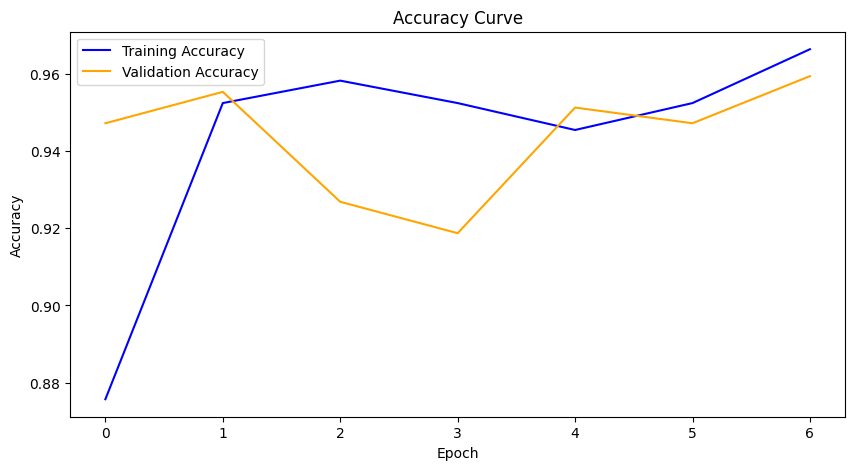

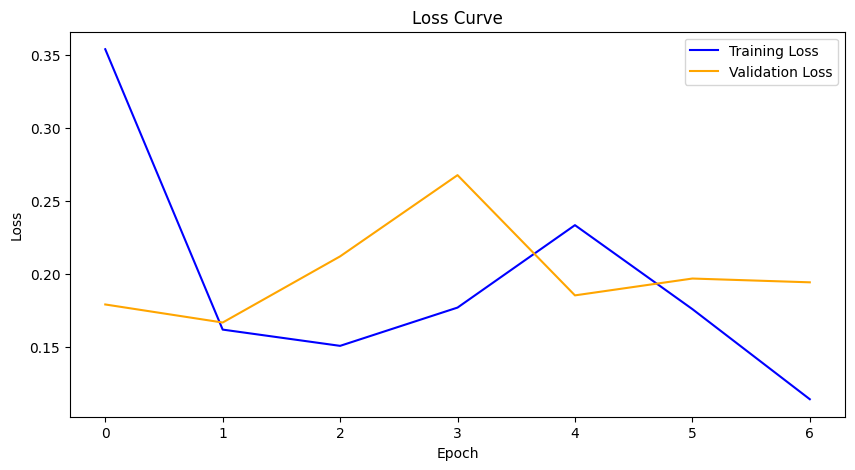

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# Load data from CSV file
data = pd.read_csv('/content/MobileNetV2.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy', color='blue')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss', color='blue')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step


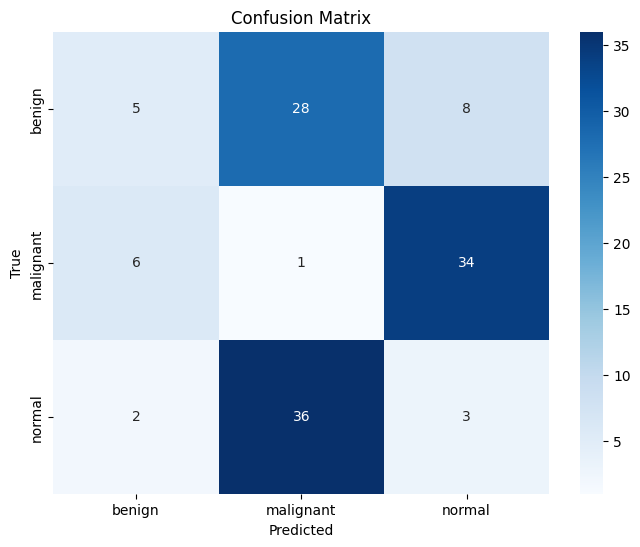

              precision    recall  f1-score   support

           0       0.38      0.12      0.19        41
           1       0.02      0.02      0.02        41
           2       0.07      0.07      0.07        41

    accuracy                           0.07       123
   macro avg       0.16      0.07      0.09       123
weighted avg       0.16      0.07      0.09       123



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = mobilenet_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices
class_names = ['benign', 'malignant', 'normal']

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)

##InceptionV3
###This model is also overfitted for our merged dataset.

In [ ]:
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_inception.trainable = False

x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

inception_model = Model(inputs=base_model_inception.input, outputs=output)
inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

inception_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 111, 111, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 111, 111, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 109, 109, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 109, 109, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 109, 109, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 109, 109, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 54, 54, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 54, 54, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
filepath = "/content/InceptionV3.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq= 2)

log_csv = CSVLogger('/content/InceptionV3.csv', separator=',', append=False)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks_list = [checkpoint1, log_csv, early_stopping]

inception_history = inception_model.fit(
    training_set,
    epochs=100,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/100
 3/14 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5104 - loss: 1.0840

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7416 - loss: 0.6456 - val_accuracy: 0.9106 - val_loss: 0.3403
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9270 - loss: 0.2637 - val_accuracy: 0.8862 - val_loss: 0.4031
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9450 - loss: 0.1964 - val_accuracy: 0.9431 - val_loss: 0.2196
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9557 - loss: 0.1775 - val_accuracy: 0.8902 - val_loss: 0.4059
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9346 - loss: 0.2229 - val_accuracy: 0.9390 - val_loss: 0.2413
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9810 - loss: 0.0843 - val_accuracy: 0.8943 - val_loss: 0.4558
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9529 - loss: 0.2006 - val_accuracy: 0.8902 - val_loss: 0.4990
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9363 - loss: 0.2404 - val_accuracy: 0.8374 -

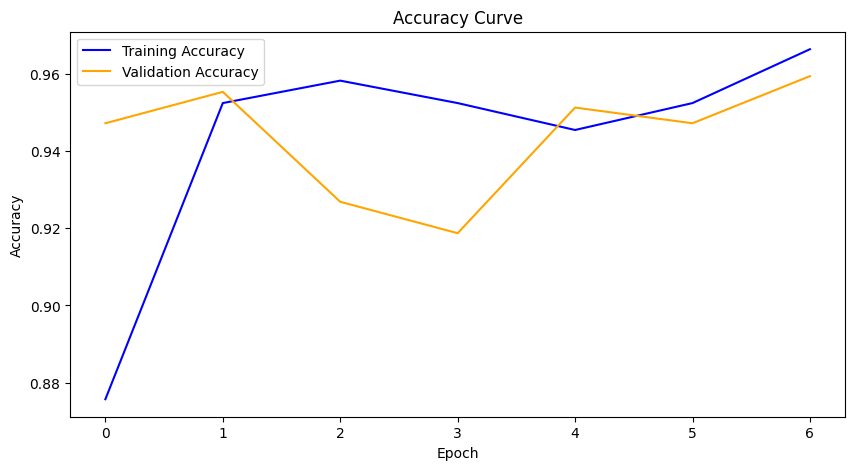

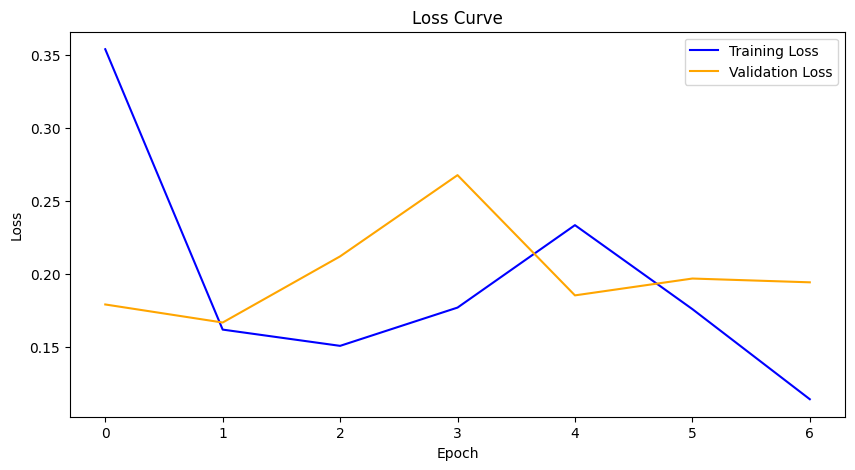

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# Load data from CSV file
data = pd.read_csv('/content/InceptionV3.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy', color='blue')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss', color='blue')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step


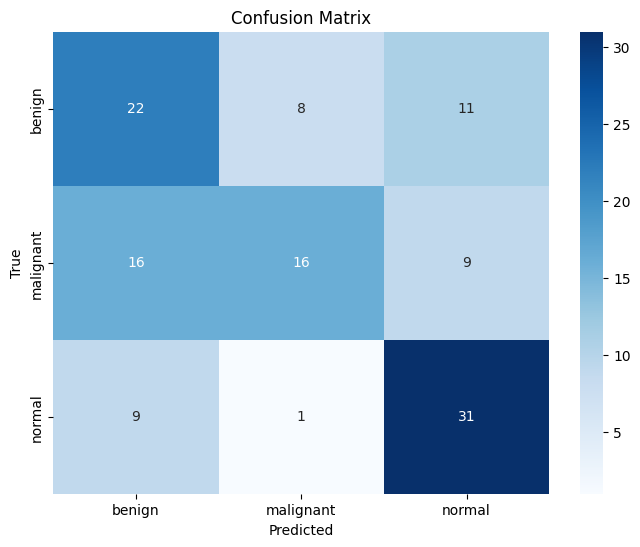

              precision    recall  f1-score   support

           0       0.47      0.54      0.50        41
           1       0.64      0.39      0.48        41
           2       0.61      0.76      0.67        41

    accuracy                           0.56       123
   macro avg       0.57      0.56      0.55       123
weighted avg       0.57      0.56      0.55       123



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = inception_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices
class_names = ['benign', 'malignant', 'normal']

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)

##EfficientNetB0
###The model gives is again overfitted for our merged model.

In [ ]:
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet.trainable = False

x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

efficientnet_model = Model(inputs=base_model_efficientnet.input, outputs=output)
efficientnet_model.summary()

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
filepath = "/content/EfficientNetB0.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq= 2)

log_csv = CSVLogger('/content/EfficientNetB0.csv', separator=',', append=False)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks_list = [checkpoint1, log_csv, early_stopping]

efficientnet_history = efficientnet_model.fit(
    training_set,
    epochs=100,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/100
 5/14 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3276 - loss: 1.4825

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3201 - loss: 1.5083 - val_accuracy: 0.3333 - val_loss: 1.1370
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3183 - loss: 1.2032 - val_accuracy: 0.3333 - val_loss: 1.1311
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3093 - loss: 1.1731 - val_accuracy: 0.3333 - val_loss: 1.1163
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.2676 - loss: 1.1706 - val_accuracy: 0.3333 - val_loss: 1.0988
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3003 - loss: 1.1581 - val_accuracy: 0.3333 - val_loss: 1.1085
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3309 - loss: 1.1499 - val_accuracy: 0.3333 - val_loss: 1.1042
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3191 - loss: 1.1525 - val_accuracy: 0.3333 - val_loss: 1.0992
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3053 - loss: 1.1667 - val_accuracy: 0.3333 - val_lo

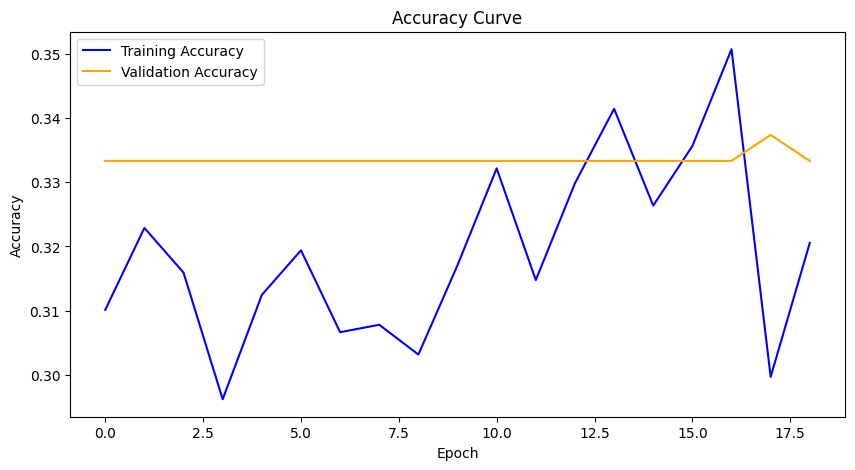

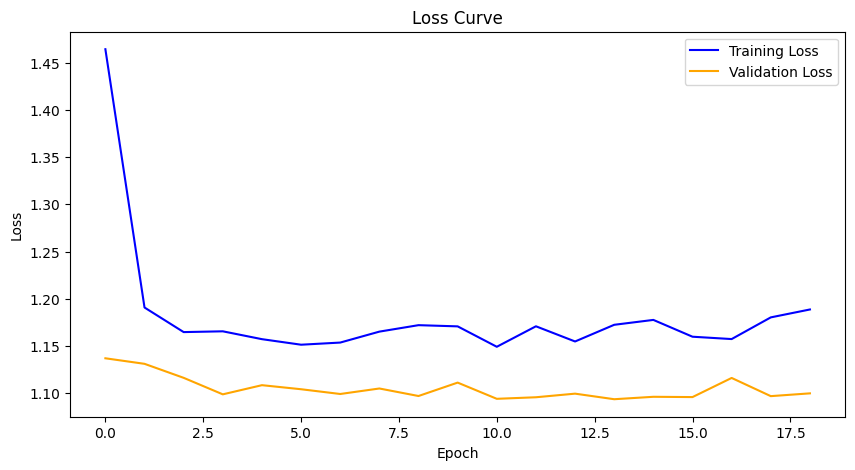

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# Load data from CSV file
data = pd.read_csv('/content/EfficientNetB0.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy', color='blue')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss', color='blue')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 9s/step


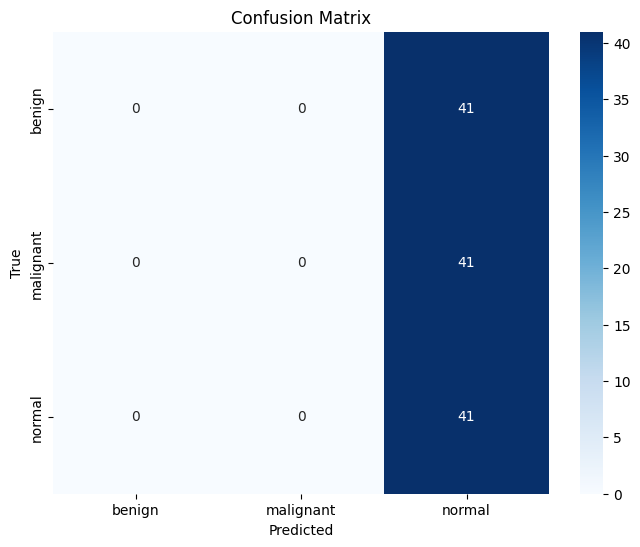

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00        41
           2       0.33      1.00      0.50        41

    accuracy                           0.33       123
   macro avg       0.11      0.33      0.17       123
weighted avg       0.11      0.33      0.17       123



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = efficientnet_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices
class_names = ['benign', 'malignant', 'normal']

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)

##MLP

In [ ]:
import tensorflow as tf

# Define the MLP model
mlp_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),  # Input layer (flattened image)
    tf.keras.layers.Dense(512, activation='relu'),  # Hidden layer with 512 neurons and ReLU activation
    tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
    tf.keras.layers.Dense(256, activation='relu'),  # Another hidden layer with 256 neurons and ReLU activation
    tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer with 3 neurons (for 3 classes) and softmax activation
])


# Compile the model
mlp_model.compile(optimizer='adam',  # You can change the optimizer if needed
              loss='categorical_crossentropy',  # Use categorical_crossentropy for multi-class classification
              metrics=['accuracy'])

# Print the model summary
mlp_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │      77,070,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,202,947 (294.51 MB)

 Trainable params: 77,202,947 (294.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filepath = "/content/MLP.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq=2)

log_csv = CSVLogger('/content/MLP.csv', separator=',', append=False)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks_list = [checkpoint1, log_csv, early_stopping]

mlp_history = mlp_model.fit(
    training_set,
    epochs=100,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.5253 - loss: 3.3129 - val_accuracy: 0.7114 - val_loss: 2.0642
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7318 - loss: 3.8050 - val_accuracy: 0.7846 - val_loss: 1.4162
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7874 - loss: 2.2256 - val_accuracy: 0.8293 - val_loss: 0.7283
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8403 - loss: 1.3335 - val_accuracy: 0.8740 - val_loss: 0.4892
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8650 - loss: 0.8354 - val_accuracy: 0.8618 - val_loss: 0.5964
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8899 - loss: 0.6583 - val_accuracy: 0.8577 - val_loss: 0.5886
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8808 - loss: 0.6431 - val_accuracy: 0.8902 - val_loss: 0.5517
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9064 - loss: 0.5935 - val_accuracy: 

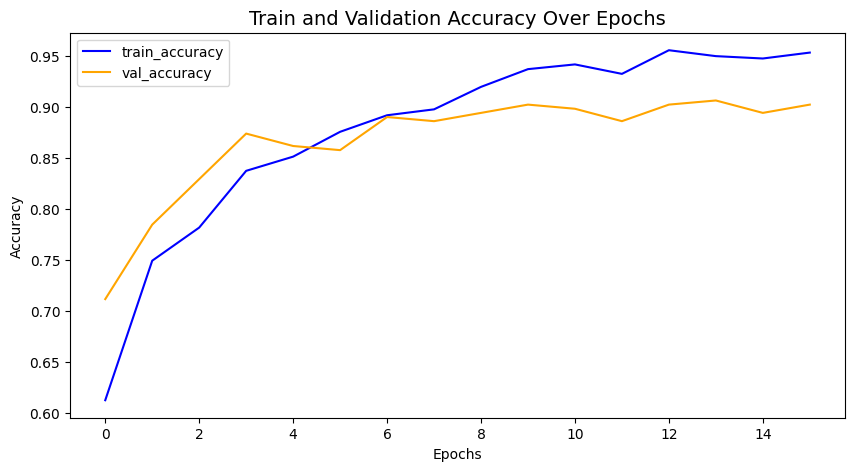

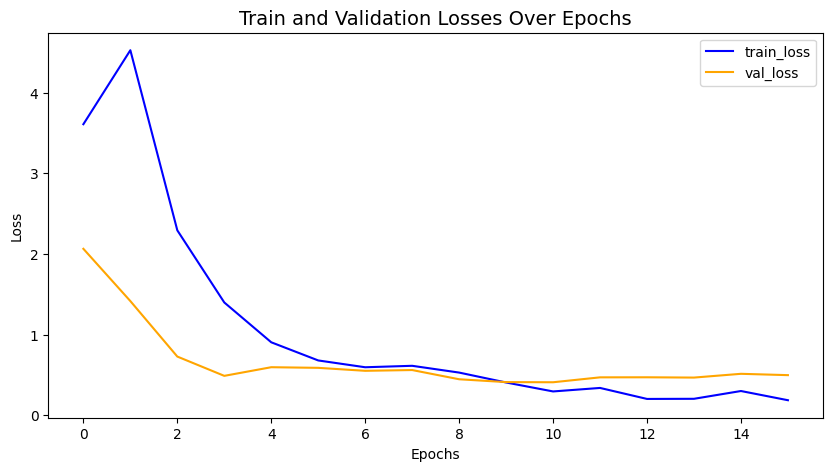

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))

plt.plot(mlp_history.history["accuracy"], label="train_accuracy", color='blue')
plt.plot(mlp_history.history["val_accuracy"], label="val_accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()

# Plot training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(mlp_history.history["loss"], label="train_loss", color='blue')
plt.plot(mlp_history.history["val_loss"], label="val_loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


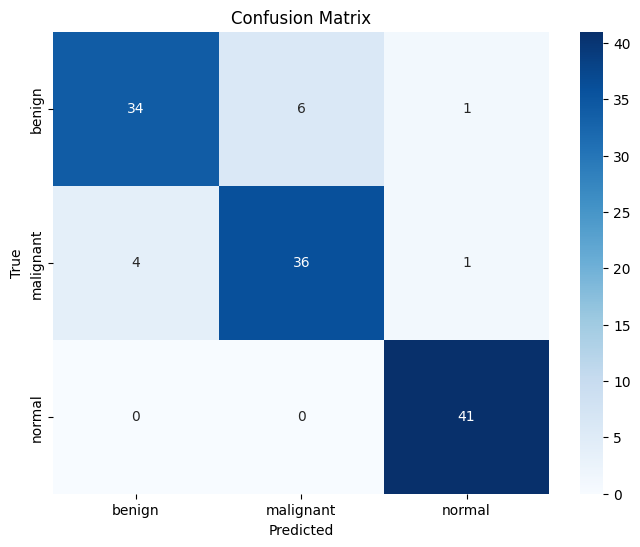

              precision    recall  f1-score   support

           0       0.89      0.83      0.86        41
           1       0.86      0.88      0.87        41
           2       0.95      1.00      0.98        41

    accuracy                           0.90       123
   macro avg       0.90      0.90      0.90       123
weighted avg       0.90      0.90      0.90       123



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = mlp_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices
class_names = ['benign', 'malignant', 'normal']

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)

##**Choosing Best two models for concatenating Hybrid Model**
In this study, I explored multiple pre-trained convolutional neural networks (CNNs), including VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0, and MLP. After extensive evaluation, ***VGG16, MobileNetV2 and MLP demonstrated superior performance***, while other models exhibited signs of overfitting, likely due to the limited dataset size and complex architectures requiring larger data.

To concatenate the strengths of both VGG16, MobileNetV2, and MLP I propose a hybrid model that combines the feature extraction capabilities of these two models. By merging their extracted feature maps, the hybrid model can achieve robust feature learning, improving classification performance.

Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization, LSTM, GlobalAveragePooling1D, MaxPooling2D, ZeroPadding2D, Conv2D, GlobalAveragePooling2D, Dense, Flatten, Concatenate, Reshape
import matplotlib.pyplot as plt
#transfer learning model

#import various transfer elarning models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

import keras.backend as K
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

### **Hybrid Model (VGG16 + ResNet50 + MLP)**

In [ ]:
# Image size and classes
IMAGE_SIZE = [224, 224]
CLASS = 3  # Number of classes (Benign, Malignant, Normal)

input_vgg16 = Input(shape=IMAGE_SIZE + [3])
input_resnet50 = Input(shape=IMAGE_SIZE + [3])

# Load Pretrained VGG16 and ResNet50 Models
vgg16_base = VGG16(input_tensor=input_vgg16, weights="imagenet", include_top=False)
resnet50_base = ResNet50(input_tensor=input_resnet50, weights="imagenet", include_top=False)

# Freeze pretrained layers
for layer in vgg16_base.layers:
    layer.trainable = False
for layer in resnet50_base.layers:
    layer.trainable = False
#______________________________________________________________________________________________________________
# Extract features
vgg = vgg16_base.output
vgg = GlobalAveragePooling2D()(vgg)
vgg = Dropout(0.5)(vgg)
vgg16_features = Flatten()(vgg)

resnet = resnet50_base.output
resnet = GlobalAveragePooling2D()(resnet)
resnet = Dropout(0.5)(resnet)
resnet50_features = Flatten()(resnet)

# Concatenate extracted features
concatenated_features = Concatenate()([vgg16_features, resnet50_features])
#______________________________________________________________________________________________________________
from tensorflow.keras.layers import Dropout # Import Dropout

# MLP Block
x = Dense(512, activation="relu")(concatenated_features)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

prediction = Dense(CLASS, activation="softmax")(x)  # Classification Output
#______________________________________________________________________________________________________________

# Build the Model
hybrid_model = Model(inputs=[input_vgg16, input_resnet50], outputs=prediction)

# Compile Model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
hybrid_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 39,748,803 (151.63 MB)

 Trainable params: 1,444,867 (5.51 MB)

 Non-trainable params: 38,303,936 (146.12 MB)

In [ ]:
training_set = tf.keras.utils.image_dataset_from_directory('/content/split_dataset/train',   #training dataset
                                            labels='inferred',
                                            image_size = (224,224),
                                            batch_size = 64,
                                            label_mode = 'categorical',
                                            shuffle = True)

val_set = tf.keras.utils.image_dataset_from_directory('/content/split_dataset/val',  #validation dataset
                                            labels='inferred',
                                            image_size = (224,224),
                                            batch_size = 64,
                                            label_mode = 'categorical',
                                            shuffle = False)

test_set = tf.keras.utils.image_dataset_from_directory('/content/split_dataset/test',  #test dataset
                                            labels='inferred',
                                            image_size = (224,224),
                                            batch_size = 64,
                                            label_mode = 'categorical',
                                            shuffle = False)

def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # Convert to float32
    image = image / 255.0  # Rescale to [0, 1]
    return (image, image),  label

training_set = training_set.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 861 files belonging to 3 classes.
Found 246 files belonging to 3 classes.
Found 123 files belonging to 3 classes.


In [ ]:
filepath = "/content/Hybrid.weights.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                               save_weights_only=True, save_best_only=True, mode='max', save_freq= 2)

log_csv = CSVLogger('/content/Hybrid.csv', separator=',', append=False)

callbacks_list = [checkpoint1, log_csv]

hybrid_history = hybrid_model.fit(
    training_set,
    epochs=100,
    validation_data=val_set,
    callbacks = callbacks_list,
    verbose = 1
)

Epoch 1/100
 2/14 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - accuracy: 0.3633 - loss: 2.0693

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3976 - loss: 1.8115 - val_accuracy: 0.6585 - val_loss: 0.8034
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 534ms/step - accuracy: 0.5404 - loss: 1.2254 - val_accuracy: 0.6626 - val_loss: 0.7228
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 614ms/step - accuracy: 0.6568 - loss: 0.8322 - val_accuracy: 0.6667 - val_loss: 0.7546
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 555ms/step - accuracy: 0.6941 - loss: 0.7145 - val_accuracy: 0.7073 - val_loss: 0.4564
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 560ms/step - accuracy: 0.7484 - loss: 0.5902 - val_accuracy: 0.6789 - val_loss: 0.4550
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 553ms/step - accuracy: 0.7901 - loss: 0.4864 - val_accuracy: 0.7805 - val_loss: 0.3674
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 542ms/step - accuracy: 0.8332 - loss: 0.4365 - val_accuracy: 0.8252 - val_loss: 0.3228
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 536ms/step - accuracy: 0.8303 - loss: 0.4098 - val_accuracy: 0.8659 -

#**Part 04: Visualize Model Performance**

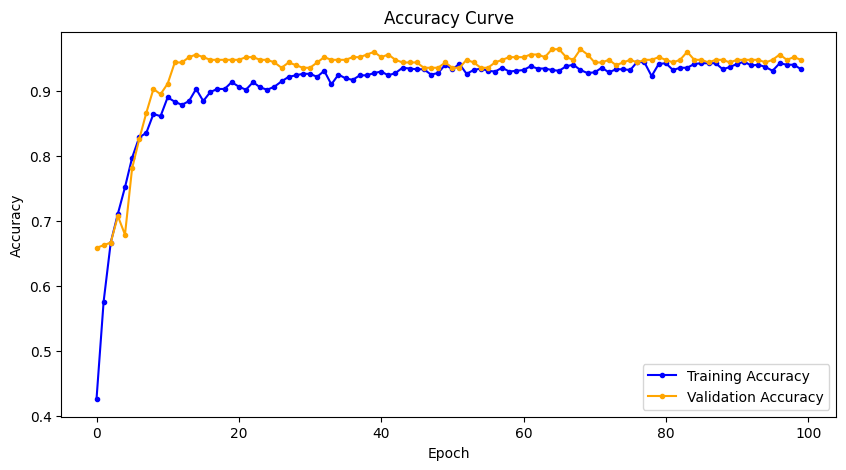

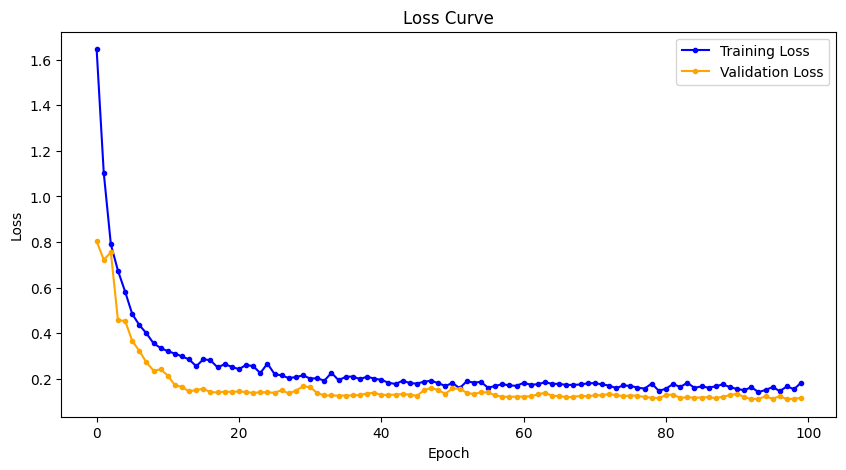

In [ ]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# Load data from CSV file
data = pd.read_csv('/content/Hybrid.csv')

# Plot accuracy
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy', color='blue', marker='.')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy', color='orange', marker='.')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
# Plot loss
plt.plot(data['epoch'], data['loss'], label='Training Loss', color='blue', marker='.')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss', color='orange', marker='.')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step


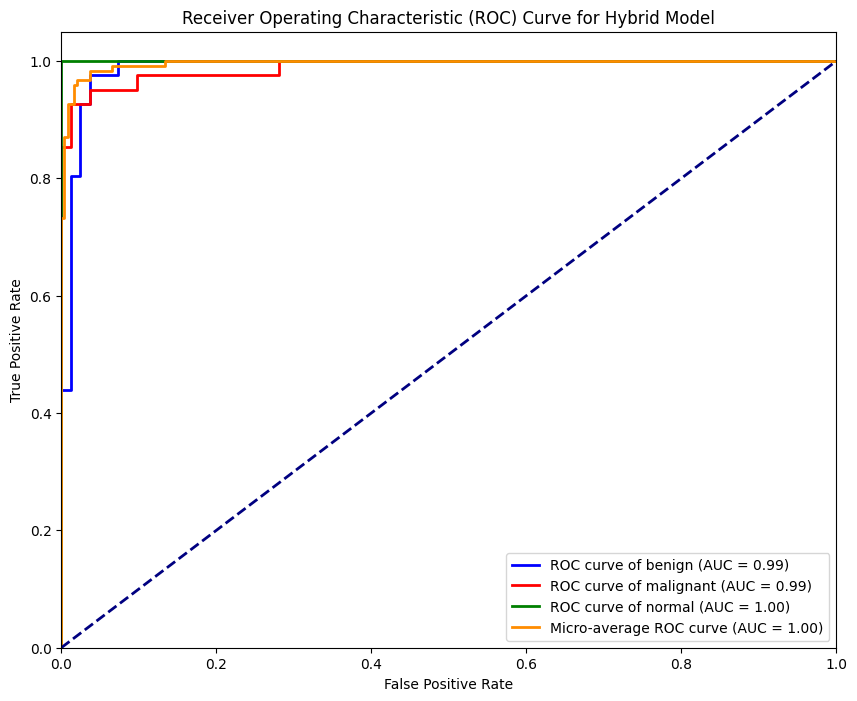

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Get predictions for the hybrid model
y_pred_hybrid = hybrid_model.predict(test_set)

# Extract true labels directly (optimized)
y_true_classes = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in test_set], axis=0)

# Class names (ensure order is correct)
class_names = ['benign', 'malignant', 'normal']

# Binarize true labels
y_true_bin = label_binarize(y_true_classes, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_hybrid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_hybrid.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2,
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Hybrid Model')
plt.legend(loc="lower right")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step


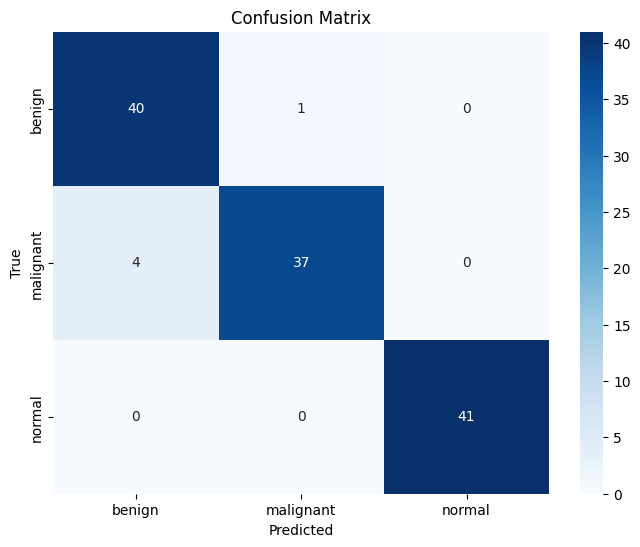

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        41
           1       0.97      0.90      0.94        41
           2       1.00      1.00      1.00        41

    accuracy                           0.96       123
   macro avg       0.96      0.96      0.96       123
weighted avg       0.96      0.96      0.96       123



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = hybrid_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices
class_names = ['benign', 'malignant', 'normal']

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print(class_report)

#**Part 05: Generate Evaluation Metrics Table**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import numpy as np
import pandas as pd


y_pred = hybrid_model.predict(test_set)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

y_true = np.concatenate([y for x, y in test_set], axis=0)  # Get true labels as one array
y_true_classes = np.argmax(y_true, axis=1)  # Convert one-hot to class indices

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
TP = np.diag(cm)  # True Positives (diagonal elements)
FP = np.sum(cm, axis=0) - TP  # False Positives (column sum - TP)
FN = np.sum(cm, axis=1) - TP  # False Negatives (row sum - TP)
TN = np.sum(cm) - (TP + FP + FN)  # True Negatives (total sum - (TP + FP + FN))

# Compute metrics
precision = TP / (TP + FP)  # Precision
recall = TP / (TP + FN)  # Recall (Sensitivity)
specificity = TN / (TN + FP)  # Specificity
f1_score_values = 2 * (precision * recall) / (precision + recall)  # F1-Score

# Additional Metrics
npv = TN / (TN + FN)  # Negative Predictive Value (NPV)
fpr = FP / (FP + TN)  # False Positive Rate (FPR)
fdr = FP / (TP + FP)  # False Discovery Rate (FDR)
fnr = FN / (TP + FN)  # False Negative Rate (FNR)
mcc = matthews_corrcoef(y_true_classes, y_pred_classes)  # MCC
accuracy = accuracy_score(y_true_classes, y_pred_classes)  # Overall Accuracy

# Store results in a DataFrame
class_names = ['Benign', 'Malignant', 'Normal']
metrics_df = pd.DataFrame({
    'Class': class_names + ['Overall'],
    'Precision': np.append(precision, np.mean(precision)),
    'Recall (Sensitivity)': np.append(recall, np.mean(recall)),
    'Specificity': np.append(specificity, np.mean(specificity)),
    'F1-Score': np.append(f1_score_values, np.mean(f1_score_values)),
    'NPV': np.append(npv, np.mean(npv)),
    'FPR': np.append(fpr, np.mean(fpr)),
    'FDR': np.append(fdr, np.mean(fdr)),
    'FNR': np.append(fnr, np.mean(fnr)),
    'MCC': np.append([None, None, None], mcc),  # MCC is overall metric
    'Overall Accuracy': np.append([None, None, None], accuracy)  # Only for overall
})

# Print the table
print(metrics_df)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step
       Class  Precision  Recall (Sensitivity)  Specificity  F1-Score  \
0     Benign   0.909091              0.975610     0.951220  0.941176   
1  Malignant   0.973684              0.902439     0.987805  0.936709   
2     Normal   1.000000              1.000000     1.000000  1.000000   
3    Overall   0.960925              0.959350     0.979675  0.959295   

        NPV       FPR       FDR       FNR       MCC Overall Accuracy  
0  0.987342  0.048780  0.090909  0.024390      None             None  
1  0.952941  0.012195  0.026316  0.097561      None             None  
2  1.000000  0.000000  0.000000  0.000000      None             None  
3  0.980094  0.020325  0.039075  0.040650  0.939863          0.95935  


In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(metrics_df)

# Save results to a CSV file
output_csv_path = "/content/evaluation_metrics_table.csv"
results_df.to_csv(output_csv_path, index=False)

print(f"Metrics saved to: {output_csv_path}")

Metrics saved to: /content/evaluation_metrics_table.csv
